# CLOUDY reader

Firstly, execute the following cell. Then navigate the table of contents

### Table of contents <a class="anchor" id="toc"></a>

1. Importing a single CLOUDY run
    1. [Continuum spectrum](#continuum)
    2. [Overview of physical quantities](#overview)
    3. [Emissivity of spectral lines and SLEDs](#emis)  
2. [Compare simulations between different grids](#compare)
3. [Molecular lines ratios](#molratios)
4. [Maximize CO(1-0) luminosity](#maxCO1)

#### The different CLOUDY grids

[1](#turbogrid). The `turbogrid`

In [25]:
# libraries
import re, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import cm
from progressbar import ProgressBar


# useful constants
nan = np.nan
c = 2.99792458e10 #cm/s
pc = 3.086e18 # cm
msun = 1.99e33 # g
lsun = 3.9e33 # erg/s
ry_ev = 13.605698 # eV in 1 Rydberg
ry_nm = 91.1270 # nm in 1 Rydberg
ry_hz = 3.2898e+15 # Hz in 1 Rydberg
co_ghz = np.array([115.27, 230.54, 345.80, 461.04, 576.27, 691.47, 
                   806.65, 921.80, 1036.91, 1151.99, 1267.01, 1381.96, 1496.92])
co_mm = 2.9979e2 / co_ghz

# seaborn options
sns.set(rc={"figure.dpi":130, 'savefig.dpi':130})
sns.set_style('ticks')
sns.set_style({'xtick.direction': 'in', 'ytick.direction': 'in',
              'xtick.top': True, 'ytick.right': True})
sns.set_context("paper", rc={"font.size":14, 
                             "axes.titlesize":16, "axes.labelsize":16,
                             'xtick.labelsize':14, 'ytick.labelsize':14, 
                             'xtick.minor.size': 0, 'ytick.minor.size': 0})

# dataframes
llab = pd.read_csv('/media/phd/cloudy/database/line_labels_long.csv', index_col='label')
emili = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name')

# useful functions
def ovrpdr(wd, filename):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    ovr = pd.read_csv(wd + subdir + filename + '.ovr', sep='\t')
    pdr = pd.read_csv(wd + subdir + filename + '.pdr', sep='\t')
    return ovr, pdr

def emis(wd, filename):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    return emis

def cosled(wd, filename, Jmax=30, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    colist = emis.columns.to_list()[1:31]
    Y = emis[colist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hcnsled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HCN')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hcosled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HCO+')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hncsled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HNC')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def old_lineNH(wd, filename, mol, J):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    sled = emis.columns[emis.columns.str.contains(mol)].to_list()
    return emis[sled[J]]

def lineNH(wd, filename, line_label, logNH):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    idx = ovrpdr(wd, ff)[1]['H colden'].sub(10**logNH).abs().idxmin()
    if np.isnan(idx):
        return np.nan
    else:
        return emis(wd, ff)[line_label].iloc[idx]

### CLOUDY output files guide

- **.cont** contains the continuum spectrum:
    - `#Cont  nu`: wavelengths in Rydberg (1 Ry = 13.605698 eV = 91.1270 nm = 3.2898e+15 Hz)
    - `incident`:  incident continuum at the illuminated face of the cloud
    - `trans`: transmitted incident continuum and does not include diffuse emission from the cloud
    - `DiffOut`: outward portion of the emitted continuum and line emission
    - `net trans`:  net transmitted continuum = `trans` + `DiffOut`
    - `reflc`: reflected continuum and is only predicted for an open geometry
    - `total`: attenuated incident continuum + `net trans` + `reflc`
    - `reflin`: sum of all reflected line emission
    - `outlin`: sum of all outward line emission
    - `lineID`:  label for the strongest line in the total spectrum (reflected plus outward) the line-center of which lies in that bin
    - `cont`: continuum edges that might contribute at that energy
    - `nLine`:  number of emission lines within that continuum bin, divided by the ratio of the energy width of the cell to the cell’s central energy, $dE/E$
- **.ele_X**:
    - `#depth`: cloud depth in cm
    - the other columns are the relative fraction of a certain ion/molecule of element $X$
- **.emis** produced with the `save last lines zone cumulative emergent` command
    - `#depth`: cloud depth in cm
    - the other columns are the cumulative flux, integrated for each zone in erg cm$^{-2}$ s$^{-1}$, of a certain line
- **.out**: the default output of every Cloudy run, described in detail in Hazy 2, Chapter 1. It contains the input file, a lot of information regarding the chemical species used in the simulation, intrinsic and emergent line intensities. For every iteration it prints the first and last zone details. It prints also all the comments (*DISASTER* if very serious, *PROBLEM* if something not expected, *NOTE* otherwise)
- **.ovr**: 
    - `#depth`: cloud depth in cm
    - `Te`: temperature in K
    - `Htot`: local heating in erg cm$^{-3}$ s$^{-1}$
    - `hden`: total hydrogen density in cm$^{-3}$
    - `eden`: electron density in cm$^{-3}$
    - various ionization and molecular fractions for H, He, C, O
    - `AV(point)`, `AV(extend)`: visual extinction (for point and extended extinction) from the illuminated face to the current position
- **.pdr**: some of the columns are the same as the **ovr** file; the rest are
    - `H colden`: total hydrogen column density in cm$^{-2}$
    - `H2*/HDEN`: ratio of 2H$_2^*$ to total hydrogen
    - `G0`: (dimensionless) intensity of the UV continuum relative to the Habing background
    - `TauV(point)`: total extinction in magnitudes in the V filter measured from the illuminated face of the cloud

# 1.1 Plot the continuum spectrum <a class="anchor" id="continuum"></a>
[(back to top)](#toc)

In [2]:
wd = '/media/phd/cloudy/gridtest/'
ff = 'xdr_h200_x200'
cont = pd.read_csv(wd + ff + '.cont', sep='\t')
print(cont.columns.to_list())

['#Cont  nu', 'incident', 'trans', 'DiffOut', 'net trans', 'reflc', 'total', 'reflin', 'outlin', 'lineID', 'cont', 'nLine']


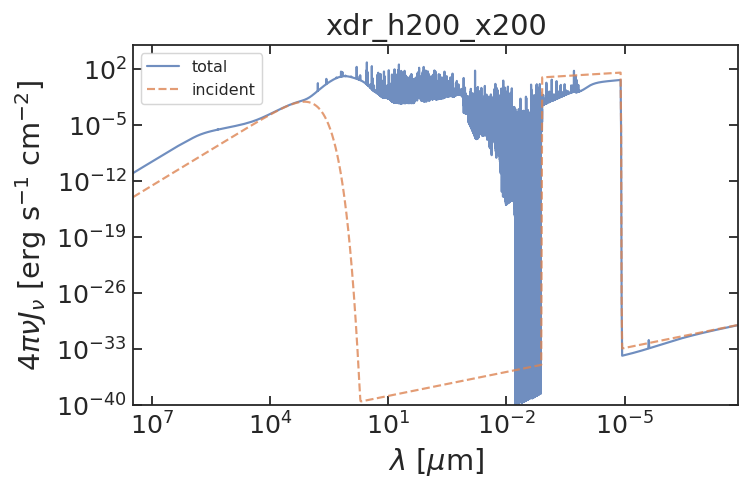

In [128]:
# wavelength X-axis in microns
X = ry_nm * 1e-3 / cont['#Cont  nu']

cols = ['total', 'incident']
lss = ['solid', 'dashed']

for i in range(len(cols)):
    q, ls = cols[i], lss[i]
    plt.loglog(X, cont[q], label=q, ls=ls, alpha=0.8)

plt.legend()
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'$4 \pi \nu J_{\nu}$ [erg s$^{-1}$ cm$^{-2}$]')
_ = plt.ylim([1e-40, 1e5])

# invert X axis
_ = plt.xlim(max(X), min(X))

# limit the x axis, e.g. in the FIR 8-1000um band
#_ = plt.xlim(1e3, 8)

plt.title(ff)
plt.tight_layout();

# 1.2 Overview of physical quantities of a CLOUDY simulation <a class="anchor" id="overview"></a>
[(back to top)](#toc)

In [10]:
wd = '/media/phd/cloudy/hagrid/xdr_h300/'
ff = 'xdr_h300_x250'
ovr = pd.read_csv(wd + ff + '.ovr', sep='\t')
pdr = pd.read_csv(wd + ff + '.pdr', sep='\t')
print('OVR', ovr.columns.to_list())
print('PDR', pdr.columns.to_list())

OVR ['#depth', 'Te', 'Htot', 'hden', 'eden', '2H_2/H', 'HI', 'HII', 'HeI', 'HeII', 'HeIII', 'CO/C', 'C1', 'C2', 'C3', 'C4', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'H2O/O', 'AV(point)', 'AV(extend)']
PDR ['#depth', 'H colden', 'Te', 'HI/HDEN', 'H2/HDEN', 'H2*/HDEN', 'CI/C', 'CO/C', 'H2O/O', 'G0', 'AV(point)', 'AV(extend)', 'TauV(point)']


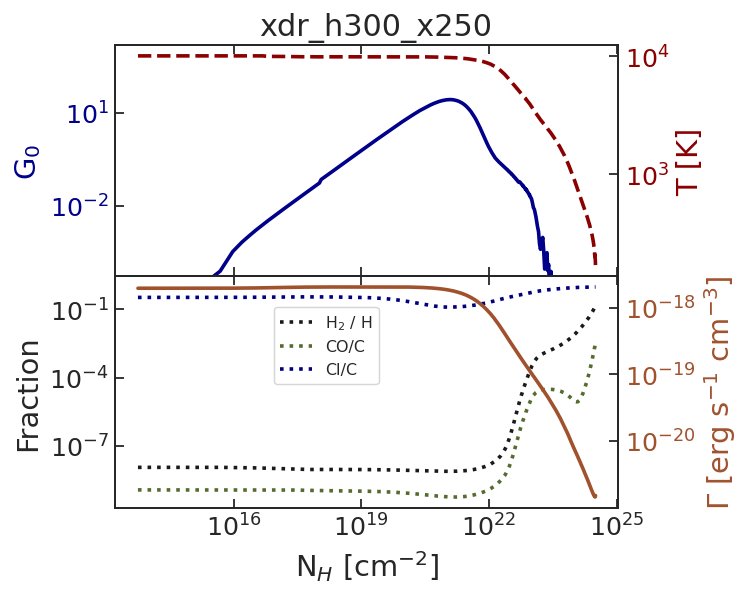

In [9]:
fig, (ax1, bx1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,5))

# x-axis
X = pdr['H colden']

# top subplot
color = 'darkblue'
ax1.set_ylabel(r'G$_0$', color=color)
ax1.loglog(X, pdr['G0'], lw=2, color=color, label='G0')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=5e-5)
#ax1.set_yticks([1e-4, 1e-2, 1e0])
color = 'darkred'
ax2 = ax1.twinx()
ax2.set_ylabel('T [K]', color=color)
ax2.loglog(X, pdr['Te'], ls='dashed', lw=2, color=color, label='T')
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0.7e1, 1.3e3])

# bottom subplot
bx1.loglog(X, pdr['H2/HDEN'], ls='dotted', c='k', lw=2, label=r'H$_2$ / H')
bx1.loglog(X, ovr['CO/C'], ls='dotted', c='darkolivegreen', lw=2, label='CO/C')
bx1.loglog(X, pdr['CI/C'], ls='dotted', c='navy', lw=2, label='CI/C')
bx1.set_ylabel('Fraction')
#bx1.set_ylim([5e-5, 5])
bx1.set_xlabel(r'N$_H$ [cm$^{-2}$]')
bx1.legend(bbox_to_anchor=(0.3,0.5))
color = 'sienna'
bx2 = bx1.twinx()
bx2.set_ylabel(r'$\Gamma$ [erg s$^{-1}$ cm$^{-3}$]', color=color)
bx2.loglog(X, ovr['Htot'], ls='solid', lw=2, color=color)
bx2.tick_params(axis='y', labelcolor=color)
#bx2.set_ylim([0.7e1, 1.3e3])

fig.suptitle(ff, y=0.92)
fig.tight_layout()
plt.subplots_adjust(hspace = 0, wspace=0)

#fig.savefig(wd + 'ovr_' + ff + '.png', dpi=180, bbox_inches='tight')

# 1.3 Plotting the line emission from the `.emis` file <a class="anchor" id="emis"></a>
[(back to top)](#toc)

1. [Lines flux vs column density](#manylines)
2. [CO SLED](#cosled)
3. [More SLEDs](#moresleds)

Next block is needed for all these subsections

In [13]:
#wd = '/media/phd/cloudy/gridtest/'
ff = 'pdr_h500_g200'
wd = '/media/phd/cloudy/ngmgrid/'
emis = emis(wd, ff)
pdr = ovrpdr(wd, ff)[1]

# list of common molecules
r = '#depth'
cosled = emis.columns.to_list()[1:31]
hcnsled = emis.columns[emis.columns.str.contains('HCN')].to_list()
hcosled = emis.columns[emis.columns.str.contains('HCO+')].to_list()
hncsled = emis.columns[emis.columns.str.contains('HNC')].to_list()
co13sled = emis.columns[emis.columns.str.contains('13CO')].to_list()
h2osled = emis.columns[emis.columns.str.contains('H2O')].to_list()
cssled = emis.columns[emis.columns.str.contains('CS')].to_list()
siosled = emis.columns[emis.columns.str.contains('SIO')].to_list()
csled = emis.columns[emis.columns.str.startswith('C  ')].to_list()
osled = emis.columns[emis.columns.str.startswith('O  ')].to_list()
nsled = emis.columns[emis.columns.str.startswith('N  ')].to_list()
hsled = emis.columns[emis.columns.str.startswith('H  ')].to_list()
h2sled = emis.columns[emis.columns.str.contains('H2  ')].to_list()

## 1.3.1 Lines flux vs. column density <a class="anchor" id="manylines"></a>
[(back to top)](#emis)

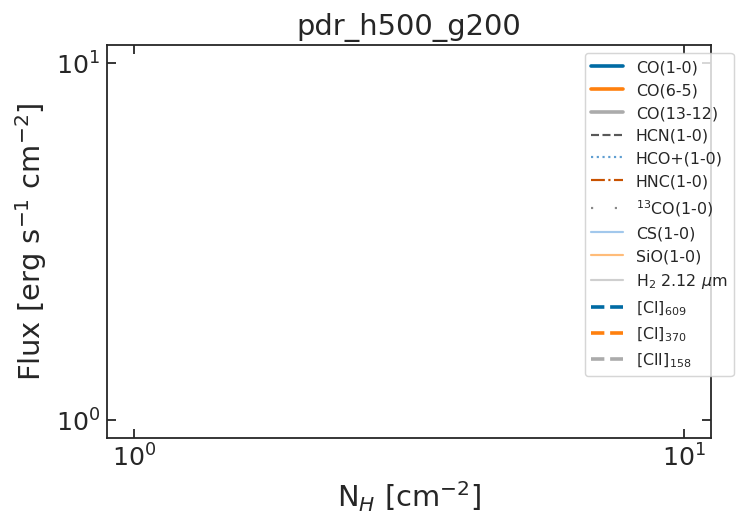

In [15]:
# plot of lines emissivity in function of column density inside the cloud
style.use('tableau-colorblind10')

# x-axis
X = pdr['H colden']

for j in [0,5,12]:
    lab = 'CO(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[cosled[j]], label=lab, lw=2)

for j in range(1):
    lab = 'HCN(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[hcnsled[j]], label=lab, ls='--')

for j in range(1):
    lab = 'HCO+(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[hcosled[j]], label=lab, ls=':')

for j in range(1):
    lab = 'HNC(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[hncsled[j]], label=lab, ls='-.')

for j in range(1):
    lab = r'$^{13}$CO(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[co13sled[j]], label=lab, ls=(0, (1, 10)))

for j in range(1):
    lab = 'CS(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[cssled[j]], label=lab)

for j in range(1):
    lab = 'SiO(' + str(j+1) + '-' + str(j) + ')'
    plt.loglog(X, emis[siosled[j]], label=lab)

for j in range(1):
    lab = r'H$_2$ 2.12 $\mu$m'
    plt.loglog(X, emis[h2sled[j]], label=lab)

# carbon lines
plt.loglog(X, emis[csled[0]], label=r'[CI]$_{609}$', lw=2, ls='--')
plt.loglog(X, emis[csled[1]], label=r'[CI]$_{370}$', lw=2, ls='--')
plt.loglog(X, emis[csled[2]], label=r'[CII]$_{158}$', lw=2, ls='--')

plt.legend(bbox_to_anchor=(1.05, 1))
_ = plt.xlabel(r'N$_H$ [cm$^{-2}$]')
_ = plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
_ = plt.xlim([3e16, 7e24])

plt.title(ff);

#plt.savefig(wd + 'molelines_' + ff + '.png', dpi=180, bbox_inches='tight')

## 1.3.2 Plotting the SLED of a molecule <a class="anchor" id="cosled"></a>
[(back to top)](#emis)

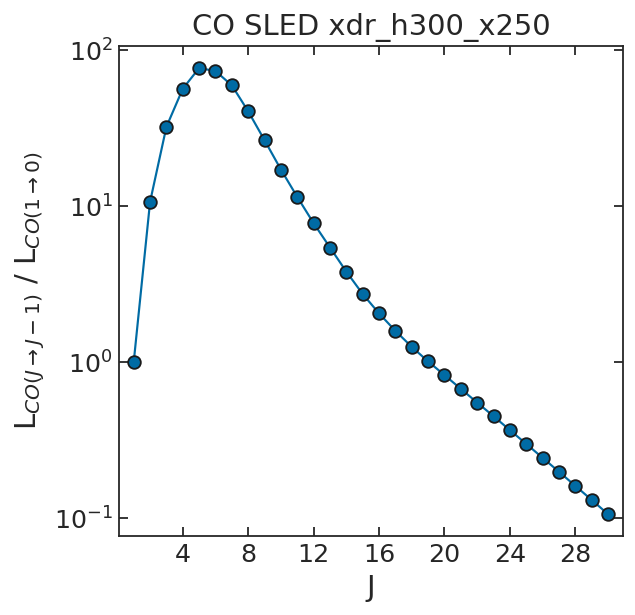

In [16]:
# if you want to normalize the flux to the (1-0) line set it True
norm = True
Jmax = 30

plt.figure(figsize=(5,5))
Y = emis[cosled[:Jmax]].iloc[-1].to_numpy()
if norm: Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 'o-', mec='k', ms=7)
plt.yscale('log')
_ = plt.xlim(0.1, Jmax+0.9)
_ = plt.xlabel('J')
_ = plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
if norm: _ = plt.ylabel(r'L$_{CO(J \rightarrow J-1)}$ / L$_{CO(1 \rightarrow 0)}$')
_ = plt.title('CO SLED ' + ff)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # force integer x-ticks

We can also plot the CO SLED at different column densities

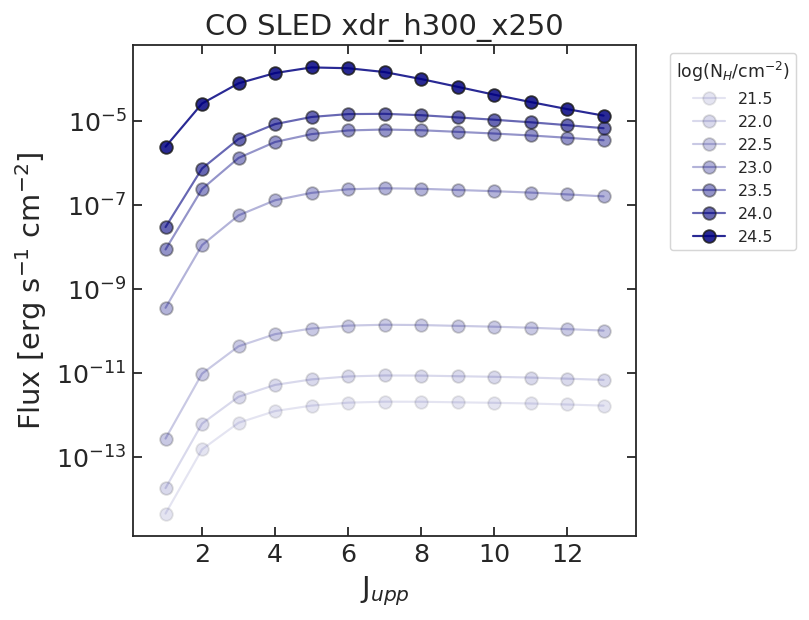

In [17]:
# if you want to normalize the flux to the (1-0) line set it True
norm = False
NHlo, NHup, NHstep = 21.5, 24.75, 0.5
alphabase = 2
Jmax = 13

plt.figure(figsize=(5,5))
for logNH in np.arange(NHlo, NHup, NHstep):
    idx = pdr['H colden'].sub(10**logNH).abs().idxmin()
    Y = emis[cosled[:Jmax]].iloc[idx].to_numpy()
    if norm: Y = Y / Y[0]
    plt.plot(range(1, Jmax+1), Y, 'o-', mec='k', ms=7, label=str(logNH),
            color='navy', alpha=alphabase**logNH/alphabase**NHup)

plt.legend(title=r'log(N$_H$/cm$^{-2}$)', bbox_to_anchor=(1.05, 1))
plt.yscale('log')
_ = plt.xlim(0.1, Jmax + 0.9)
_ = plt.xticks(np.arange(1, Jmax+1))
_ = plt.xlabel(r'J$_{upp}$')
_ = plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
if norm: _ = plt.ylabel(r'L$_{CO(\, J \rightarrow J-1)}$ / L$_{CO(1 \rightarrow 0)}$')
plt.title('CO SLED ' + ff);
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # force integer x-ticks

## 1.3.3 Plotting the SLEDs of many molecules <a class="anchor" id="moresleds"></a>
[(back to top)](#emis)

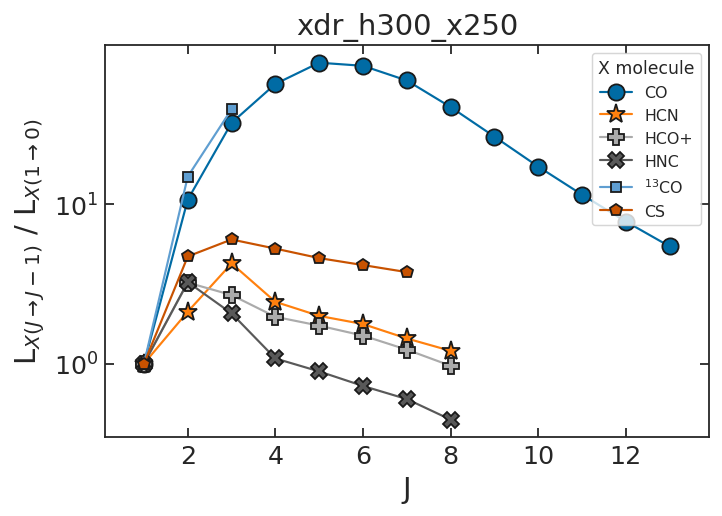

In [13]:
ms = 9 # marker size

Y = emis[cosled].iloc[-1].to_numpy()[:13]
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 'o-', label='CO', ms=ms, mec='k')

Y = emis[hcnsled].iloc[-1].to_numpy()
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, '*-', label='HCN', ms=ms+2, mec='k')

Y = emis[hcosled].iloc[-1].to_numpy()
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 'P-', label='HCO+', ms=ms, mec='k')

Y = emis[hncsled].iloc[-1].to_numpy()
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 'X-', label='HNC', ms=ms, mec='k')

Y = emis[co13sled].iloc[-1].to_numpy()
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 's-', label=r'$^{13}$CO', ms=ms-4, mec='k')

Y = emis[cssled].iloc[-1].to_numpy()
Y = Y / Y[0]
plt.plot(range(1,len(Y)+1), Y, 'p-', label='CS', ms=ms-2, mec='k')

plt.legend(title='X molecule', loc='upper right')
plt.title(ff);
plt.yscale('log')
_ = plt.xlim(0.1, 13.9)
_ = plt.xlabel('J')
_ = plt.ylabel(r'L$_{X(J \rightarrow J-1)}$ / L$_{X(1 \rightarrow 0)}$')

Or, in absolute flux values

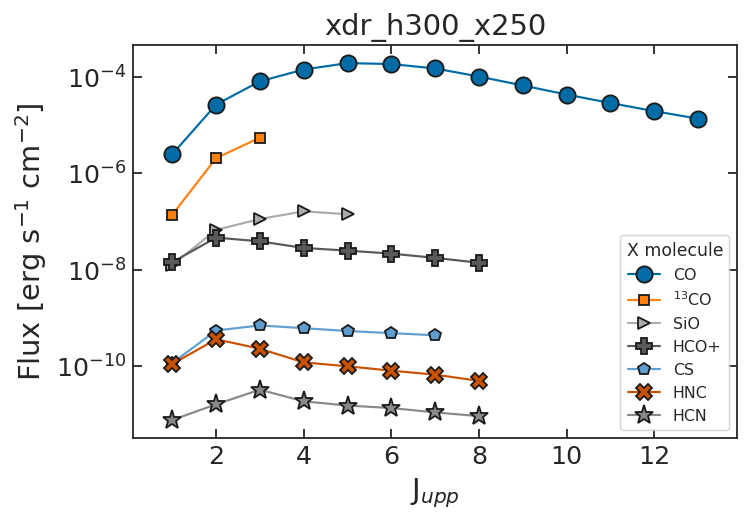

In [20]:
ms = 9 # marker size

Y = emis[cosled].iloc[-1].to_numpy()[:13]
plt.plot(range(1,len(Y)+1), Y, 'o-', label='CO', ms=ms, mec='k')

Y = emis[co13sled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, 's-', label=r'$^{13}$CO', ms=ms-4, mec='k')

Y = emis[siosled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, '>-', label='SiO', ms=ms-2, mec='k')

Y = emis[hcosled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, 'P-', label='HCO+', ms=ms, mec='k')

Y = emis[cssled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, 'p-', label='CS', ms=ms-2, mec='k')

Y = emis[hncsled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, 'X-', label='HNC', ms=ms, mec='k')

Y = emis[hcnsled].iloc[-1].to_numpy()
plt.plot(range(1,len(Y)+1), Y, '*-', label='HCN', ms=ms+2, mec='k')

plt.legend(title='X molecule')
plt.title(ff);
plt.yscale('log')
_ = plt.xlim(0.1, 13.9)
_ = plt.xlabel(r'J$_{upp}$')
_ = plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')

# 2. Compare simulations between different grids <a class="anchor" id="compare"></a>
[(back to top)](#toc)

In [5]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
filelist = ['xdr_h400_x125', 'xdr_h600_x125', 'xdr_h400_x350', 'xdr_h600_x350']

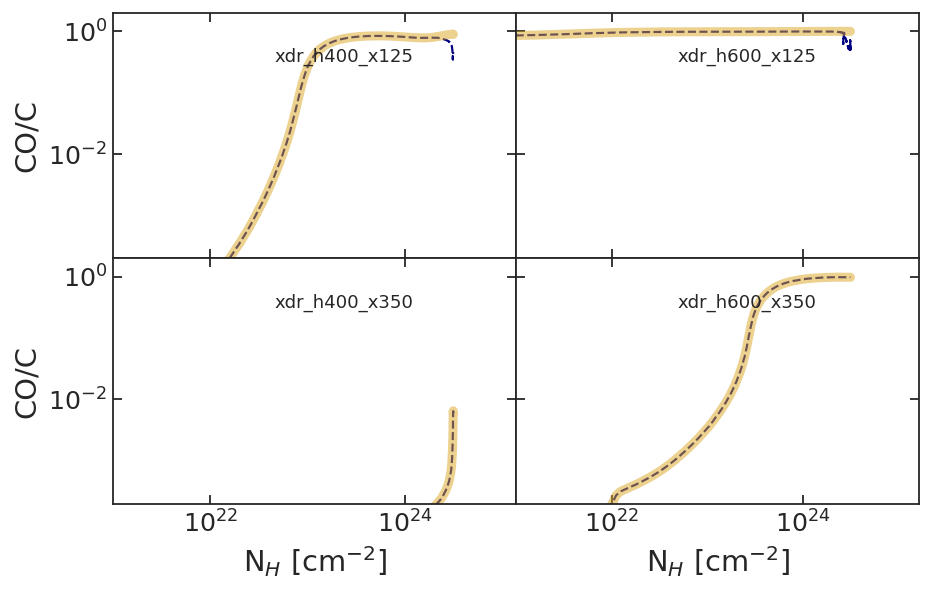

In [6]:
qq = 'CO/C'

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    ovr1, pdr1 = ovrpdr(wd1, ff)
    ovr2, pdr2 = ovrpdr(wd2, ff)
    ax.loglog(pdr1['H colden'], pdr1[qq], c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], pdr2[qq], c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.4, 0.8, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([2e-4, 2.])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=qq)
    ax.label_outer()

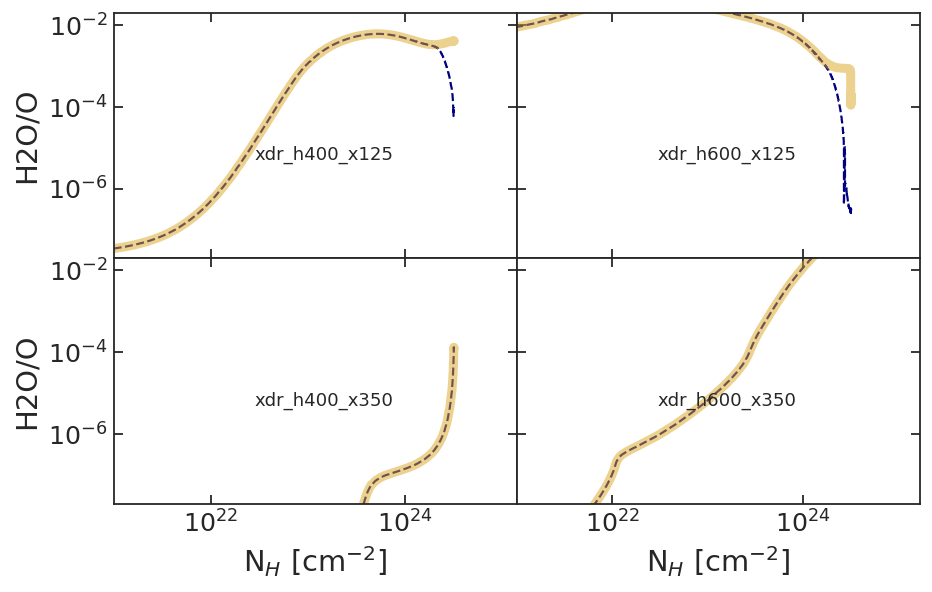

In [7]:
qq = 'H2O/O'

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    ovr1, pdr1 = ovrpdr(wd1, ff)
    ovr2, pdr2 = ovrpdr(wd2, ff)
    ax.loglog(pdr1['H colden'], pdr1[qq], c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], pdr2[qq], c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.35, 0.4, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([2e-8, 2e-2])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=qq)
    ax.label_outer()

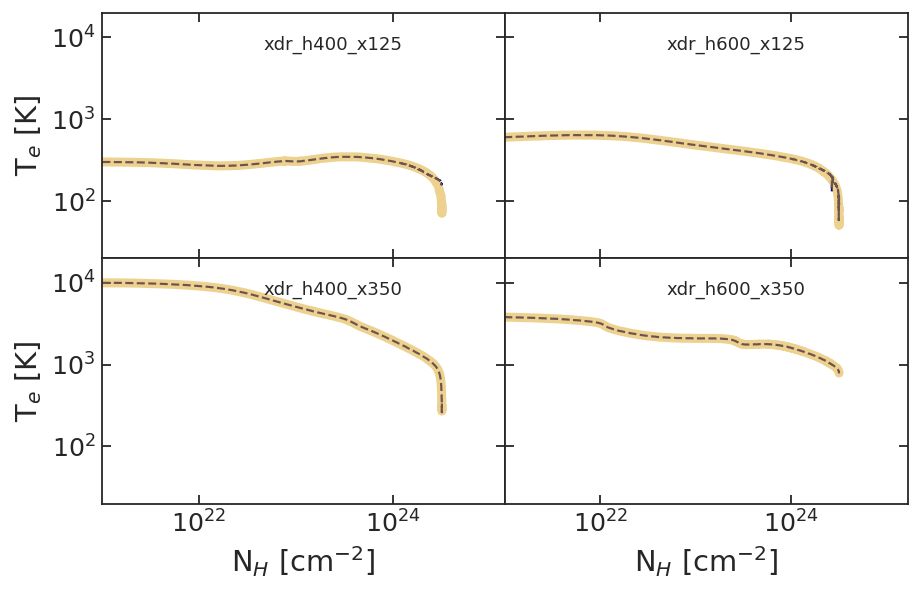

In [10]:
qq = 'Te'

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    ovr1, pdr1 = ovrpdr(wd1, ff)
    ovr2, pdr2 = ovrpdr(wd2, ff)
    ax.loglog(pdr1['H colden'], pdr1[qq], c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], pdr2[qq], c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.4, 0.85, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([2e1, 2e4])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=r'T$_e$ [K]')
    ax.label_outer()

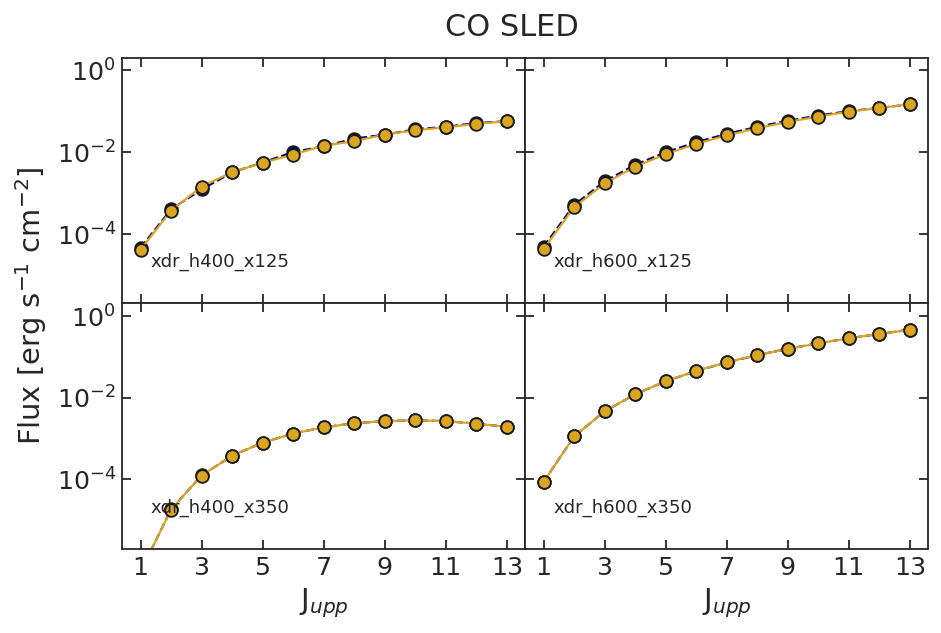

In [14]:
# if you want to normalize the flux to the (1-0) line set it True
norm = False
Jmax = 13

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

fig.suptitle(r'CO SLED', y=0.95)
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    Y1 = cosled(wd1, ff, Jmax, norm)
    Y2 = cosled(wd2, ff, Jmax, norm)
    ax.plot(range(1,len(Y1)+1), Y1, 'o', mec='k', ms=7, c=c1, ls=ls1)
    ax.plot(range(1,len(Y2)+1), Y2, 'o', mec='k', ms=7, c=c2, ls=ls2)
    ax.text(0.07, 0.15, transform=ax.transAxes, size=10, s=ff)
    ax.set_yscale('log')
    ax.set_ylim([2e-6, 2e0])
    
for ax in axs:
    ax.set(xlabel=r'J$_{upp}$', xticks=np.arange(1,14,2))
    ax.label_outer()

# common y label
fig.text(0.02, 0.5, s=r'Flux [erg s$^{-1}$ cm$^{-2}$]',
         fontsize=16, va='center', rotation='vertical');


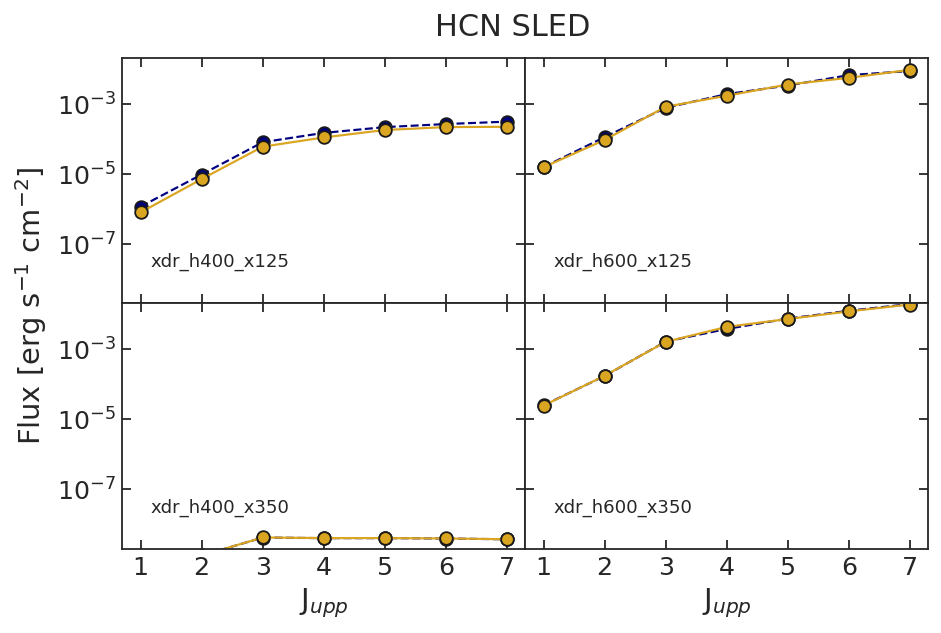

In [20]:
# if you want to normalize the flux to the (1-0) line set it True
norm = False
Jmax = 7

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

fig.suptitle(r'HCN SLED', y=0.95)
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    Y1 = hcnsled(wd1, ff, Jmax, norm)
    Y2 = hcnsled(wd2, ff, Jmax, norm)
    ax.plot(range(1,len(Y1)+1), Y1, 'o', mec='k', ms=7, c=c1, ls=ls1)
    ax.plot(range(1,len(Y2)+1), Y2, 'o', mec='k', ms=7, c=c2, ls=ls2)
    ax.text(0.07, 0.15, transform=ax.transAxes, size=10, s=ff)
    ax.set_yscale('log')
    ax.set_ylim([2e-9, 2e-2])
    
for ax in axs:
    ax.set(xlabel=r'J$_{upp}$', xticks=np.arange(1,8))
    ax.label_outer()

# common y label
fig.text(0.02, 0.5, s=r'Flux [erg s$^{-1}$ cm$^{-2}$]',
         fontsize=16, va='center', rotation='vertical');

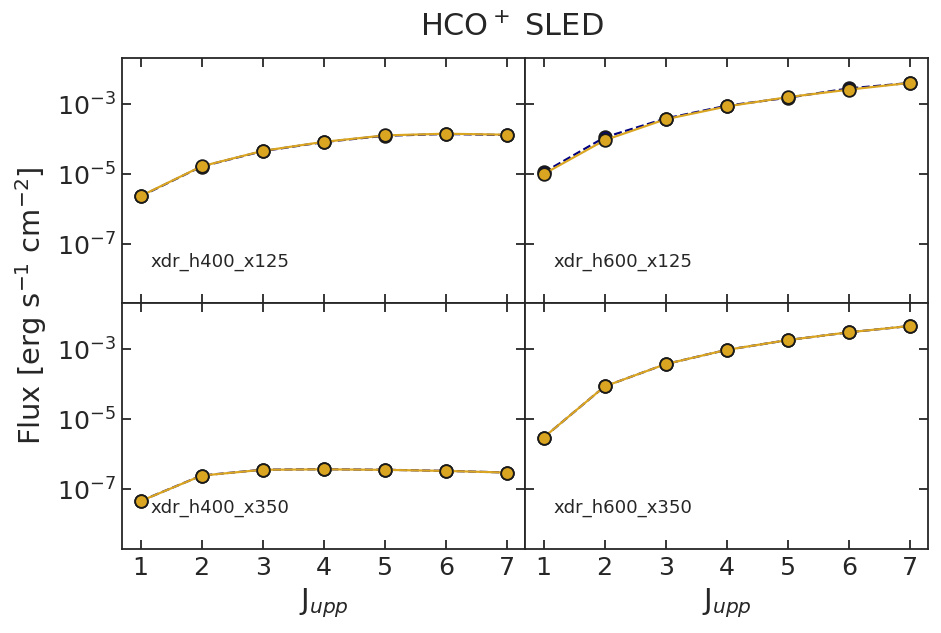

In [22]:
# if you want to normalize the flux to the (1-0) line set it True
norm = False
Jmax = 7

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

fig.suptitle(r'HCO$^+$ SLED', y=0.95)
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    Y1 = hcosled(wd1, ff, Jmax, norm)
    Y2 = hcosled(wd2, ff, Jmax, norm)
    ax.plot(range(1,len(Y1)+1), Y1, 'o', mec='k', ms=7, c=c1, ls=ls1)
    ax.plot(range(1,len(Y2)+1), Y2, 'o', mec='k', ms=7, c=c2, ls=ls2)
    ax.text(0.07, 0.15, transform=ax.transAxes, size=10, s=ff)
    ax.set_yscale('log')
    ax.set_ylim([2e-9, 2e-2])
    
for ax in axs:
    ax.set(xlabel=r'J$_{upp}$', xticks=np.arange(1,8))
    ax.label_outer()

# common y label
fig.text(0.02, 0.5, s=r'Flux [erg s$^{-1}$ cm$^{-2}$]',
         fontsize=16, va='center', rotation='vertical');

# 3. Molecular line ratios <a class="anchor" id="molratios"></a>
[(back to top)](#toc)

1. [Results from the literature](#hcn_liter)
    1. [Imanishi+2018](#imanishi18)
    2. [Viti+2014](#viti14)
2. [Our CLOUDY results](#hcn_cloudy)
    1. [HCN/HCO+ (J=4-3) as function of NH](#hcnhco43_NH)
    2. [HCN/HCO+ (J=4-3)](#hcnhco43)
    3. [HCN/HCO+ (J=3-2)](#hcnhco32)
    4. [HCN/HNC (J=4-3)](#hcnhnc43)
    5. [CO(13-12)/CO(6-5)](#co136)
    6. [CO(6-5)/CO(1-0)](#co61)
    7. [CO selected line ratios](#coratios)

## 3.1 Results from the literature <a class="anchor" id="hcn_liter"></a>
[(back to subtop)](#molratios)

In [224]:
# useful line rest-frame frequencies
CO10_GHz = 115.271
CO21_GHz = 230.537
CO32_GHz = 345.796
CO65_GHz = 691.471
HCN10_GHz = 88.632
HCO10_GHz = 89.188
HCN32_GHz = 265.89
HCO32_GHz = 267.56
HNC32_GHz = 271.981
HCN43_GHz = 354.505
HCO43_GHz = 356.734
HNC43_GHz = 362.630
CS21_GHz = 97.981
CS54_GHz = 244.936
CS76_GHz = 342.883
SiO65_GHz = 260.518
CH3OH = 364.859

### 3.1.1 Imanishi+2018: sample of 11 (U)LIRGs <a class="anchor" id="imanishi18"></a>
[(back to subtop)](#molratios)

[Imanishi et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...856..143I/abstract) presents J=4-3 of HCN, HCO+, and HNC and J=3-2 of HNC (and some additional lines) for a sample of 11 (U)LIRGs

In [176]:
ima18 = pd.DataFrame({
    'Name': ['IRAS08572+3915', 'IRAS19254-7245', 'IRAS12112+0305_NE', 'IRAS12112+0305_SW', 'IRAS22491-1808', 
             'NGC1614_Npeak', 'NGC1614_Speak', 'NGC1614_25rad', 'IRAS12127-1412', 'IRAS15250+3609', 'IRAS13451+1232', 
             'IRAS06035-7102', 'IRAS13509+0442', 'IRAS20414-1651'],
    'z': [0.0580, 0.0617, 0.0730, 0.0730, 0.0776, 0.0160, 0.0160, 0.0160, 0.1332, 0.0552, 0.1215, 0.0795, 0.1364, 0.0870],
    'logLIR': [12.1, 12.1, 12.3, 12.3, 12.2, 11.7, 11.7, 11.7, 12.2, 12.0, 12.3, 12.2, 12.3, 12.3],
    'HNC32_Jy': [0.71, 1.6, 7.8, 0.47, 6.0, 0.28, 0.49, 2.3, 0.83, 6.7, 0.73, 1.8, 0.90, nan],
    'HNC32_Jy_err': [0.10, 0.2, 0.3, 0.14, 0.3, 0.07, 0.36, 0.9, 0.16, 0.3, 0.16, 0.2, 0.08, nan],
    'HCN43_Jy': [nan, 9.7, 6.6, nan, nan, nan, nan, nan, nan, 6.8, 1.7, nan, 0.78, 5.4],
    'HCN43_Jy_err': [nan, 0.6, 1.0, nan, nan, nan, nan, nan, nan, 0.4, 0.3, nan, 0.12, 1.3],
    'HCO43_Jy': [nan, 6.1, 4.8, 1.6, nan, nan, nan, nan, nan, 2.3, 3.2, nan, 0.95, 2.5],
    'HCO43_Jy_err': [nan, 0.4, 0.7, 0.6, nan, nan, nan, nan, nan, 0.5, 0.3, nan, 0.13, 0.3],
    'HNC43_Jy': [nan, 1.4, 11, nan, nan, nan, nan, nan, nan, 10, nan, nan, 0.80, 1.4],
    'HNC43_Jy_err': [nan, 0.3, 1, nan, nan, nan, nan, nan, nan, 1, nan, nan, 0.16, 0.3],
    'HNC32_Lsun': [1.2, 3.2, 22, 1.3, 19, nan, nan, 0.3, 8.0, 11, 5.8, 6.0, 9.1, nan],
    'HNC32_Lsun_err': [0.2, 0.4, 1, 0.4, 1, nan, nan, 0.1, 1.5, 1, 1.3, 0.7, 0.8, nan],
    'HCN43_Lsun': [7.3, 25, 24, nan, 30, nan, nan, 0.48, 15, 14, 18, nan, 10, 28],
    'HCN43_Lsun_err': [0.7, 2, 4, nan, 2, nan, nan, 0.14, 3, 1, 3, nan, 2, 7],
    'HCO43_Lsun': [9.7, 16, 18, 5.9, 22, nan, nan, 2.7, 9.6, 4.8, 32, nan, 13, 13],
    'HCO43_Lsun_err': [0.7, 1, 3, 2.2, 2, nan, nan, 0.2, 2.4, 1.0, 3, nan, 2, 2],
    'HNC43_Lsun': [nan, 3.7, 37, nan, 29, nan, nan, 0.30, 12, 21, nan, nan, 11, 7.5],
    'HNC43_Lsun_err': [nan, 0.8, 4, nan, 1, nan, nan, 0.09, 3, 2, nan, nan, 2, 1.6],
    'HNC32_LKkm': [1.9, 4.9, 34, 2.0, 30, nan, nan, 0.47, 12, 17, 9.0, 9.3, 14, nan],
    'HNC32_LKkm_err': [0.3, 0.6, 1, 0.6, 1, nan, nan, 0.18, 2, 1, 2.0, 1.0, 1, nan],
    'HCN43_LKkm': [5.1, 18, 17, nan, 21, nan, nan, 0.34, 11, 9.9, 12, nan, 7.2, 20],
    'HCN43_LKkm_err': [0.5, 1, 3, nan, 1, nan, nan, 0.10, 2, 0.6, 2, nan, 1.1, 5],
    'HCO43_LKkm': [6.6, 11, 12, 4.0, 15, nan, nan, 1.9, 6.6, 3.3, 22, nan, 8.6, 9.0],
    'HCO43_LKkm_err': [0.5, 1, 2, 1.5, 1, nan, nan, 0.2, 1.6, 0.7, 2, nan, 1.2, 1.1],
    'HNC43_LKkm': [nan, 2.4, 24, nan, 19, nan, nan, 0.19, 7.6, 14, nan, nan, 7.0, 4.9],
    'HNC43_LKkm_err': [nan, 0.5, 2, nan, 1, nan, nan, 0.06, 2.2, 1, nan, nan, 1.4, 1.0],
    'CS54_Jy': [0.44, nan, 1.4, 0.14, 2.7, nan, nan, nan, nan, nan, nan, nan, nan, nan],
    'CS54_Jy_err': [0.04, nan, 0.1, 0.03, 0.1, nan, nan, nan, nan, nan, nan, nan, nan, nan],
    'CS76_Jy': [nan, nan, 1.3, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0],
    'CS76_Jy_err': [nan, nan, 0.3, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2],
    'SiO65_Jy': [0.077, nan, nan, nan, 0.74, nan, nan, nan, nan, nan, nan, nan, nan, nan],
    'SiO65_Jy_err': [0.037, nan, nan, nan, 0.05, nan, nan, nan, nan, nan, nan, nan, nan, nan],
    'CH3OH_Jy': [nan, 0.62, 4.6, nan, nan, nan, nan, nan, nan, 3.7, nan, nan, nan, nan],
    'CH3OH_Jy_err': [nan, 0.30, 0.3, nan, nan, nan, nan, nan, nan, 0.4, nan, nan, nan, nan],
    'HCNr43_Jy': [1.3, 0.9, 0.8, nan, 0.9, nan, nan, 0.6, 0.9, 1.3, 0.6, nan, 0.7, 1.3],
    'HCNr43_Jy_err': [0.2, 0.2, 0.2, nan, 0.2, nan, nan, 0.2, 0.2, 0.2, 0.1, nan, 0.1, 0.3],
    'HCOr43_Jy': [1.4, 0.8, 1.0, 1.2, 1.5, nan, nan, 1.0, 0.8, 1.2, 0.8, nan, 0.7, 0.8],
    'HCOr43_Jy_err': [0.2, 0.1, 0.2, 0.5, 0.2, nan, nan, 0.2, 0.2, 0.3, 0.1, nan, 0.1, 0.1],
    'HNCr43_Jy': [nan, 0.9, 1.4, nan, 1.2, nan, nan, 0.8, 1.1, 1.5, nan, nan, 0.9, nan],
    'HNCr43_Jy_err': [nan, 0.2, 0.2, nan, 0.2, nan, nan, 0.4, 0.3, 0.2, nan, nan, 0.2, nan],
    'HCNHCO43_Jy': [0.8, 1.6, 1.4, nan, 1.4, nan, nan, 0.18, 1.5, 3.0, 0.6, nan, 0.8, 2.1],
    'HCNHCO43_Jy_err': [0.1, 0.3, 0.3, nan, 0.1, nan, nan, 0.06, 0.5, 0.7, 0.1, nan, 0.2, 0.6],
    'HCNHCO32_Jy': [0.9, 1.4, 1.8, 0.5, 2.3, nan, nan, 0.33, 1.3, 2.6, 0.7, 0.8, 0.8, 1.4],
    'HCNHCO32_Jy_err': [0.1, 0.2, 0.3, 0.2, 0.2, nan, nan, 0.11, 0.2, 0.4, 0.1, 0.1, 0.1, 0.2],
    'HCNHNC43_Jy': [nan, 6.8, 0.6, nan, 1.1, nan, nan, 1.6, 1.3, 0.7, nan, nan, 1.0, 3.9],
    'HCNHNC43_Jy_err': [nan, 1.8, 0.1, nan, 0.1, nan, nan, 0.7, 0.4, 0.1, nan, nan, 0.2, 1.3],
    'HCNHNC32_Jy': [3.6, 6.4, 1.0, 1.4, 1.4, nan, nan, 2.2, 1.6, 0.8, 3.8, 2.7, 1.2, nan],
    'HCNHNC32_Jy_err': [0.6, 1.0, 0.2, 0.6, 0.2, nan, nan, 1.1, 0.3, 0.1, 0.9, 0.4, 0.2, nan]
}).set_index('Name')

In [200]:
# convert to line ratio in luminosities
ima18['HCNr43_Lsun'] = ima18['HCNr43_Jy'] * HCN43_GHz/HCN32_GHz
ima18['HCNr43_Lsun_err'] = ima18['HCNr43_Jy_err'] * HCN43_GHz/HCN32_GHz
ima18['HCOr43_Lsun'] = ima18['HCOr43_Jy'] * HCO43_GHz/HCO32_GHz
ima18['HCOr43_Lsun_err'] = ima18['HCOr43_Jy_err'] * HCO43_GHz/HCO32_GHz
ima18['HNCr43_Lsun'] = ima18['HNCr43_Jy'] * HNC43_GHz/HNC32_GHz
ima18['HNCr43_Lsun_err'] = ima18['HNCr43_Jy_err'] * HNC43_GHz/HNC32_GHz
ima18['HCNHCO43_Lsun'] = ima18['HCNHCO43_Jy'] * HCN43_GHz/HCO43_GHz
ima18['HCNHCO43_Lsun_err'] = ima18['HCNHCO43_Jy_err'] * HCN43_GHz/HCO43_GHz
ima18['HCNHCO32_Lsun'] = ima18['HCNHCO32_Jy'] * HCN32_GHz/HCO32_GHz
ima18['HCNHCO32_Lsun_err'] = ima18['HCNHCO32_Jy_err'] * HCN32_GHz/HCO32_GHz
ima18['HCNHNC43_Lsun'] = ima18['HCNHNC43_Jy'] * HCN43_GHz/HNC43_GHz
ima18['HCNHNC43_Lsun_err'] = ima18['HCNHNC43_Jy_err'] * HCN43_GHz/HNC43_GHz
ima18['HCNHNC32_Lsun'] = ima18['HCNHNC32_Jy'] * HCN32_GHz/HNC32_GHz
ima18['HCNHNC32_Lsun_err'] = ima18['HCNHNC32_Jy_err'] * HCN32_GHz/HNC32_GHz

In [201]:
ima18.to_csv('./data/imanishi18.csv')

### 3.1.2 Viti+2014: NGC 1068 <a class="anchor" id="viti14"></a>
[(back to subtop)](#molratios)

[Viti et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...570A..28V/abstract) is Paper II to [Garcia-Burillo et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...567A.125G/abstract), both relative to NGC 1068

In [221]:
vit14 = pd.DataFrame({
    'Zone': ['Eknot', 'Wknot', 'AGN', 'CND_N', 'CND_S', 'SBring'],
    'CO10_Kkm': [597.33, 500.47, 310.87, 203.57, 298.23, 115.29],
    'CO21_Kkm': [1480.28, 823.21, 773.35, 554.65, 482.57, nan],
    'CO32_Kkm': [2346.72, 1587.95, 911.03, 833.28, 429.84, 160.51],
    'CO65_Kkm': [2712.7, 937.20, 1024.85, 783.62, 366.60, nan],
    'HCO10_Kkm': [404.37, 236.20, 152.15, 178.47, 91.69, 20.22],
    'HCO43_Kkm': [251.18, 82.18, 82.52, 58.09, 27.73, 2.22],
    'HCN10_Kkm': [821.32, 466.06, 291.49, 312.71, 143.12, 19.84],
    'HCN43_Kkm': [639.47, 233.47, 174.29, 130.02, 75.58, 2.22],
    'CS21_Kkm': [18.46, 20.28, 20.97, 21.07, 14.54, 0.56],
    'CS76_Kkm': [8.26, 5.23, 8.33, 7.61, 6.89, nan]
}).set_index('Zone')

In [222]:
# errors are 15% for ALMA Band 7, 30% for Band 9 and 10% for PdBI observations
for ll in ['CO10', 'CO21', 'HCO10', 'HCN10', 'CS21']:
    vit14[ll + '_Kkm_err'] = vit14[ll + '_Kkm'] * 0.10
for ll in ['CO32', 'HCO43', 'HCN43', 'CS76']:
    vit14[ll + '_Kkm_err'] = vit14[ll + '_Kkm'] * 0.15
for ll in ['CO65']:
    vit14[ll + '_Kkm_err'] = vit14[ll + '_Kkm'] * 0.30

In [225]:
vit14['HCNHCO43_Lsun'] = vit14['HCN43_Kkm'] / vit14['HCO43_Kkm'] * (HCN43_GHz / HCO43_GHz)**3
vit14['HCNHCO43_Lsun_err'] = vit14['HCN43_Kkm_err'] / vit14['HCO43_Kkm_err'] * (HCN43_GHz / HCO43_GHz)**3

In [227]:
vit14.to_csv('./data/viti14.csv')

## 3.2 Our CLOUDY results <a class="anchor" id="hcn_cloudy"></a>
[(back to subtop)](#molratios)

In [335]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
print(len(hden), 'densities from', hden[0], 'to', hden[-1], '[Log(cm^-3)]')
print(len(G0), 'FUV fluxes from', G0[0]+2.8, 'to', G0[-1]+2.8, '[Log(G0)]')
print(len(FX), 'X-ray fluxes from', FX[0], 'to', FX[-1], '[Log(erg/s/cm2)]')

23 densities from 1.0 to 6.5 [Log(cm^-3)]
25 FUV fluxes from 0.0 to 6.0 [Log(G0)]
21 X-ray fluxes from -1.0 to 4.0 [Log(erg/s/cm2)]


#### HCN/HCO+ ratios

In [253]:
# HCN/HCO+ PDR
hcratio10_pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
hcratio10_pdr_NGM = hcratio10_pdr.copy()
hcratio32_pdr = hcratio10_pdr.copy()
hcratio32_pdr_NGM = hcratio10_pdr.copy()
hcratio43_pdr = hcratio10_pdr.copy()
hcratio43_pdr_NGM = hcratio10_pdr.copy()
for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for g in G0:
        gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        hcratio10_pdr.loc[hname, gname] = hcnsled(wd1, ff)[0] / hcosled(wd1, ff)[0]
        hcratio10_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[0] / hcosled(wd2, ff)[0]
        hcratio32_pdr.loc[hname, gname] = hcnsled(wd1, ff)[2] / hcosled(wd1, ff)[2]
        hcratio32_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[2] / hcosled(wd2, ff)[2]
        hcratio43_pdr.loc[hname, gname] = hcnsled(wd1, ff)[3] / hcosled(wd1, ff)[3]
        hcratio43_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[3] / hcosled(wd2, ff)[3]

In [254]:
# HCN/HCO+ XDR
hcratio10_xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
hcratio10_xdr_NGM = hcratio10_xdr.copy()
hcratio32_xdr = hcratio10_xdr.copy()
hcratio32_xdr_NGM = hcratio10_xdr.copy()
hcratio43_xdr = hcratio10_xdr.copy()
hcratio43_xdr_NGM = hcratio10_xdr.copy()
for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for x in FX:
        xname = 'x' + ('%.2f' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        hcratio10_xdr.loc[hname, xname] = hcnsled(wd1, ff)[0] / hcosled(wd1, ff)[0]
        hcratio10_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[0] / hcosled(wd2, ff)[0]
        hcratio32_xdr.loc[hname, xname] = hcnsled(wd1, ff)[2] / hcosled(wd1, ff)[2]
        hcratio32_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[2] / hcosled(wd2, ff)[2]
        hcratio43_xdr.loc[hname, xname] = hcnsled(wd1, ff)[3] / hcosled(wd1, ff)[3]
        hcratio43_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[3] / hcosled(wd2, ff)[3]

In [255]:
# save results
hcratio10_pdr.to_csv(wd1 + 'HCN_HCOp_10_ratio_PDR.csv')
hcratio10_pdr_NGM.to_csv(wd2 + 'HCN_HCOp_10_ratio_PDR.csv')
hcratio10_xdr.to_csv(wd1 + 'HCN_HCOp_10_ratio_XDR.csv')
hcratio10_xdr_NGM.to_csv(wd2 + 'HCN_HCOp_10_ratio_XDR.csv')
hcratio32_pdr.to_csv(wd1 + 'HCN_HCOp_32_ratio_PDR.csv')
hcratio32_pdr_NGM.to_csv(wd2 + 'HCN_HCOp_32_ratio_PDR.csv')
hcratio32_xdr.to_csv(wd1 + 'HCN_HCOp_32_ratio_XDR.csv')
hcratio32_xdr_NGM.to_csv(wd2 + 'HCN_HCOp_32_ratio_XDR.csv')
hcratio43_pdr.to_csv(wd1 + 'HCN_HCOp_43_ratio_PDR.csv')
hcratio43_pdr_NGM.to_csv(wd2 + 'HCN_HCOp_43_ratio_PDR.csv')
hcratio43_xdr.to_csv(wd1 + 'HCN_HCOp_43_ratio_XDR.csv')
hcratio43_xdr_NGM.to_csv(wd2 + 'HCN_HCOp_43_ratio_XDR.csv')

#### HCN/HNC ratios

In [367]:
# HCN/HNC PDR
hnratio10_pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
hnratio10_pdr_NGM = hnratio10_pdr.copy()
hnratio32_pdr = hnratio10_pdr.copy()
hnratio32_pdr_NGM = hnratio10_pdr.copy()
hnratio43_pdr = hnratio10_pdr.copy()
hnratio43_pdr_NGM = hnratio10_pdr.copy()
for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for g in G0:
        gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        hnratio10_pdr.loc[hname, gname] = hcnsled(wd1, ff)[0] / hncsled(wd1, ff)[0]
        hnratio10_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[0] / hncsled(wd2, ff)[0]
        hnratio32_pdr.loc[hname, gname] = hcnsled(wd1, ff)[2] / hncsled(wd1, ff)[2]
        hnratio32_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[2] / hncsled(wd2, ff)[2]
        hnratio43_pdr.loc[hname, gname] = hcnsled(wd1, ff)[3] / hncsled(wd1, ff)[3]
        hnratio43_pdr_NGM.loc[hname, gname] = hcnsled(wd2, ff)[3] / hncsled(wd2, ff)[3]

In [369]:
# HCN/HNC XDR
hnratio10_xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
hnratio10_xdr_NGM = hnratio10_xdr.copy()
hnratio32_xdr = hnratio10_xdr.copy()
hnratio32_xdr_NGM = hnratio10_xdr.copy()
hnratio43_xdr = hnratio10_xdr.copy()
hnratio43_xdr_NGM = hnratio10_xdr.copy()
for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for x in FX:
        xname = 'x' + ('%.2f' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        hnratio10_xdr.loc[hname, xname] = hcnsled(wd1, ff)[0] / hncsled(wd1, ff)[0]
        hnratio10_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[0] / hncsled(wd2, ff)[0]
        hnratio32_xdr.loc[hname, xname] = hcnsled(wd1, ff)[2] / hncsled(wd1, ff)[2]
        hnratio32_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[2] / hncsled(wd2, ff)[2]
        hnratio43_xdr.loc[hname, xname] = hcnsled(wd1, ff)[3] / hncsled(wd1, ff)[3]
        hnratio43_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[3] / hncsled(wd2, ff)[3]

/tmp/ipykernel_14644/3048329094.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  hnratio10_xdr.loc[hname, xname] = hcnsled(wd1, ff)[0] / hncsled(wd1, ff)[0]
/tmp/ipykernel_14644/3048329094.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  hnratio10_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[0] / hncsled(wd2, ff)[0]
/tmp/ipykernel_14644/3048329094.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  hnratio32_xdr.loc[hname, xname] = hcnsled(wd1, ff)[2] / hncsled(wd1, ff)[2]
/tmp/ipykernel_14644/3048329094.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  hnratio32_xdr_NGM.loc[hname, xname] = hcnsled(wd2, ff)[2] / hncsled(wd2, ff)[2]
/tmp/ipykernel_14644/3048329094.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  hnratio43_xdr.loc[hname, xname] = hcnsled(wd1, ff)[3] / hncsled(wd1, ff)[3]
/tmp/ipykernel_14644/3048329094.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  

In [370]:
# save results
hnratio10_pdr.to_csv(wd1 + 'HCN_HNC_10_ratio_PDR.csv')
hnratio10_pdr_NGM.to_csv(wd2 + 'HCN_HNC_10_ratio_PDR.csv')
hnratio10_xdr.to_csv(wd1 + 'HCN_HNC_10_ratio_XDR.csv')
hnratio10_xdr_NGM.to_csv(wd2 + 'HCN_HNC_10_ratio_XDR.csv')
hnratio32_pdr.to_csv(wd1 + 'HCN_HNC_32_ratio_PDR.csv')
hnratio32_pdr_NGM.to_csv(wd2 + 'HCN_HNC_32_ratio_PDR.csv')
hnratio32_xdr.to_csv(wd1 + 'HCN_HNC_32_ratio_XDR.csv')
hnratio32_xdr_NGM.to_csv(wd2 + 'HCN_HNC_32_ratio_XDR.csv')
hnratio43_pdr.to_csv(wd1 + 'HCN_HNC_43_ratio_PDR.csv')
hnratio43_pdr_NGM.to_csv(wd2 + 'HCN_HNC_43_ratio_PDR.csv')
hnratio43_xdr.to_csv(wd1 + 'HCN_HNC_43_ratio_XDR.csv')
hnratio43_xdr_NGM.to_csv(wd2 + 'HCN_HNC_43_ratio_XDR.csv')

#### CO ratios

In [353]:
# CO ratios PDR
co61_pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
co61_pdr_NGM = co61_pdr.copy()
co81_pdr = co61_pdr.copy()
co81_pdr_NGM = co61_pdr.copy()
co131_pdr = co61_pdr.copy()
co131_pdr_NGM = co61_pdr.copy()
co96_pdr = co61_pdr.copy()
co96_pdr_NGM = co61_pdr.copy()
co116_pdr = co61_pdr.copy()
co116_pdr_NGM = co61_pdr.copy()
co136_pdr = co61_pdr.copy()
co136_pdr_NGM = co61_pdr.copy()

for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for g in G0:
        gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        cosled1, cosled2 = cosled(wd1, ff, Jmax=13), cosled(wd2, ff, Jmax=13)
        co61_pdr.loc[hname, gname] = cosled1[5] / cosled1[0]
        co61_pdr_NGM.loc[hname, gname] = cosled2[5] / cosled2[0]
        co81_pdr.loc[hname, gname] = cosled1[7] / cosled1[0]
        co81_pdr_NGM.loc[hname, gname] = cosled2[7] / cosled2[0]
        co131_pdr.loc[hname, gname] = cosled1[12] / cosled1[0]
        co131_pdr_NGM.loc[hname, gname] = cosled2[12] / cosled2[0]
        co96_pdr.loc[hname, gname] = cosled1[8] / cosled1[5]
        co96_pdr_NGM.loc[hname, gname] = cosled2[8] / cosled2[5]
        co116_pdr.loc[hname, gname] = cosled1[10] / cosled1[5]
        co116_pdr_NGM.loc[hname, gname] = cosled2[10] / cosled2[5]
        co136_pdr.loc[hname, gname] = cosled1[12] / cosled1[5]
        co136_pdr_NGM.loc[hname, gname] = cosled2[12] / cosled2[5]

In [354]:
# CO ratios XDR
co61_xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                            columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
co61_xdr_NGM = co61_xdr.copy()
co81_xdr = co61_xdr.copy()
co81_xdr_NGM = co61_xdr.copy()
co131_xdr = co61_xdr.copy()
co131_xdr_NGM = co61_xdr.copy()
co96_xdr = co61_xdr.copy()
co96_xdr_NGM = co61_xdr.copy()
co116_xdr = co61_xdr.copy()
co116_xdr_NGM = co61_xdr.copy()
co136_xdr = co61_xdr.copy()
co136_xdr_NGM = co61_xdr.copy()

for h in hden:
    hname = 'h' + ('%.2f' % h).replace('.', '')
    this = []
    for x in FX:
        xname = 'x' + ('%.2f' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        cosled1, cosled2 = cosled(wd1, ff, Jmax=13), cosled(wd2, ff, Jmax=13)
        co61_xdr.loc[hname, xname] = cosled1[5] / cosled1[0]
        co61_xdr_NGM.loc[hname, xname] = cosled2[5] / cosled2[0]
        co81_xdr.loc[hname, xname] = cosled1[7] / cosled1[0]
        co81_xdr_NGM.loc[hname, xname] = cosled2[7] / cosled2[0]
        co131_xdr.loc[hname, xname] = cosled1[12] / cosled1[0]
        co131_xdr_NGM.loc[hname, xname] = cosled2[12] / cosled2[0]
        co96_xdr.loc[hname, xname] = cosled1[8] / cosled1[5]
        co96_xdr_NGM.loc[hname, xname] = cosled2[8] / cosled2[5]
        co116_xdr.loc[hname, xname] = cosled1[10] / cosled1[5]
        co116_xdr_NGM.loc[hname, xname] = cosled2[10] / cosled2[5]
        co136_xdr.loc[hname, xname] = cosled1[12] / cosled1[5]
        co136_xdr_NGM.loc[hname, xname] = cosled2[12] / cosled2[5]

In [355]:
# save results
co61_pdr.to_csv(wd1 + 'CO_61_ratio_PDR.csv')
co61_pdr_NGM.to_csv(wd2 + 'CO_61_ratio_PDR.csv')
co81_pdr.to_csv(wd1 + 'CO_81_ratio_PDR.csv')
co81_pdr_NGM.to_csv(wd2 + 'CO_81_ratio_PDR.csv')
co131_pdr.to_csv(wd1 + 'CO_131_ratio_PDR.csv')
co131_pdr_NGM.to_csv(wd2 + 'CO_131_ratio_PDR.csv')
co96_pdr.to_csv(wd1 + 'CO_96_ratio_PDR.csv')
co96_pdr_NGM.to_csv(wd2 + 'CO_96_ratio_PDR.csv')
co116_pdr.to_csv(wd1 + 'CO_116_ratio_PDR.csv')
co116_pdr_NGM.to_csv(wd2 + 'CO_116_ratio_PDR.csv')
co136_pdr.to_csv(wd1 + 'CO_136_ratio_PDR.csv')
co136_pdr_NGM.to_csv(wd2 + 'CO_136_ratio_PDR.csv')
co61_xdr.to_csv(wd1 + 'CO_61_ratio_XDR.csv')
co61_xdr_NGM.to_csv(wd2 + 'CO_61_ratio_XDR.csv')
co81_xdr.to_csv(wd1 + 'CO_81_ratio_XDR.csv')
co81_xdr_NGM.to_csv(wd2 + 'CO_81_ratio_XDR.csv')
co131_xdr.to_csv(wd1 + 'CO_131_ratio_XDR.csv')
co131_xdr_NGM.to_csv(wd2 + 'CO_131_ratio_XDR.csv')
co96_xdr.to_csv(wd1 + 'CO_96_ratio_XDR.csv')
co96_xdr_NGM.to_csv(wd2 + 'CO_96_ratio_XDR.csv')
co116_xdr.to_csv(wd1 + 'CO_116_ratio_XDR.csv')
co116_xdr_NGM.to_csv(wd2 + 'CO_116_ratio_XDR.csv')
co136_xdr.to_csv(wd1 + 'CO_136_ratio_XDR.csv')
co136_xdr_NGM.to_csv(wd2 + 'CO_136_ratio_XDR.csv')

### HCN/HCO+ (J=2-1) as function of cloud's column density

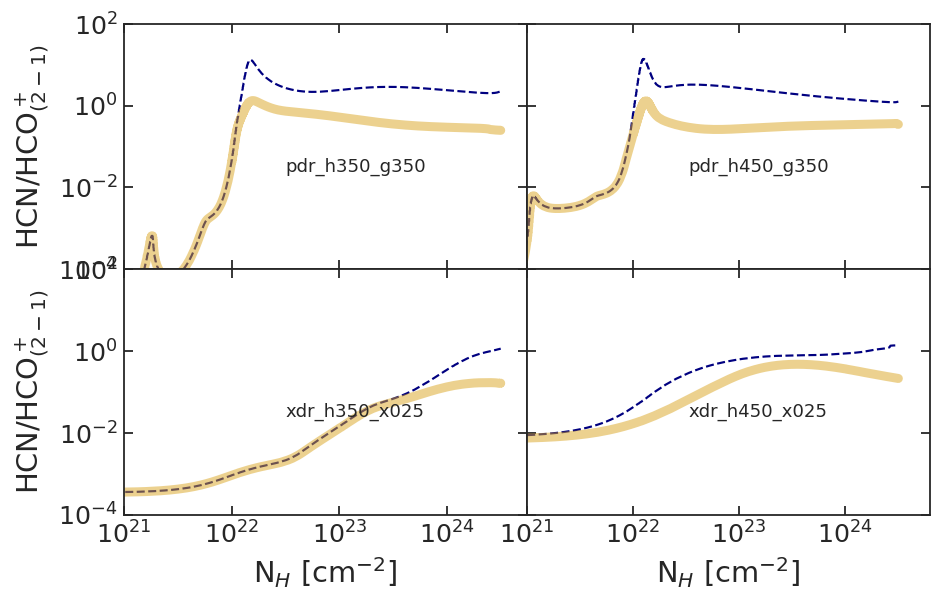

In [11]:
# PDR
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
filelist = ['pdr_h350_g350', 'pdr_h450_g350', 'xdr_h350_x025', 'xdr_h450_x025']

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    hcn21 = old_lineNH(wd1, ff, 'HCN', 1)
    hcn21_NGM = old_lineNH(wd2, ff, 'HCN', 1)
    hco21 = old_lineNH(wd1, ff, 'HCO', 1)
    hco21_NGM = old_lineNH(wd2, ff, 'HCO', 1)
    pdr1 = ovrpdr(wd1, ff)[1]
    pdr2 = ovrpdr(wd2, ff)[1]
    ax.loglog(pdr1['H colden'], hcn21/hco21, c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], hcn21_NGM/hco21_NGM, c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.4, 0.4, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([1e-4, 1e2])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=r'HCN/HCO$^+_{(2-1)}$')
    ax.label_outer()

plt.savefig('/media/phd/collab/fransalv/HCN2_HCO+2_ratio_depth.png', bbox_inches='tight', dpi=300)

But let's check the absolute values of these two molecular lines

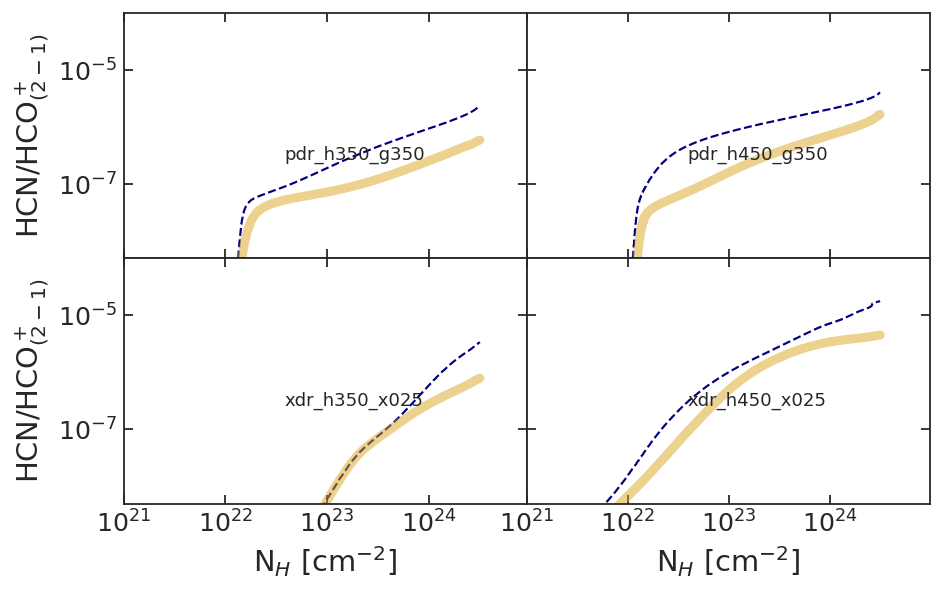

In [6]:
# PDR
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
filelist = ['pdr_h350_g350', 'pdr_h450_g350', 'xdr_h350_x025', 'xdr_h450_x025']

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    hcn21 = old_lineNH(wd1, ff, 'HCN', 1)
    hcn21_NGM = old_lineNH(wd2, ff, 'HCN', 1)
    hco21 = old_lineNH(wd1, ff, 'HCO', 1)
    hco21_NGM = old_lineNH(wd2, ff, 'HCO', 1)
    pdr1 = ovrpdr(wd1, ff)[1]
    pdr2 = ovrpdr(wd2, ff)[1]
    ax.loglog(pdr1['H colden'], hcn21, c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], hcn21_NGM, c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.4, 0.4, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([5e-9, 1e-4])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=r'HCN/HCO$^+_{(2-1)}$')
    ax.label_outer()

#plt.savefig('/media/phd/collab/fransalv/HCN2_HCO+2_ratio_depth.png', bbox_inches='tight', dpi=300)

### HCN/HCO+ (J=4-3) as function of cloud's column density <a class="anchor" id="hcnhco43_NH"></a>
[(back to subtop)](#molratios)

This is to check if there are differences between the two grids (molecules condensations on grains ON or OFF) in how the molecular emission builds up within a cloud. Let's first do it for 4 representative runs of PDR and XDR, then we can calculate the difference between every run between the two grids and plot this difference instead?

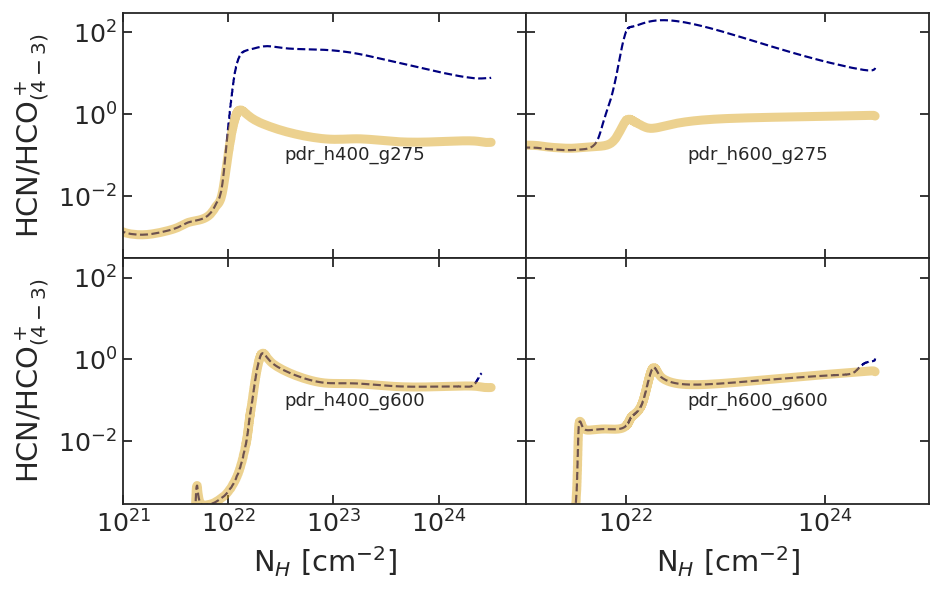

In [300]:
# PDR
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
filelist = ['pdr_h400_g275', 'pdr_h600_g275', 'pdr_h400_g600', 'pdr_h600_g600']

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    hcn43 = old_lineNH(wd1, ff, 'HCN', 3)
    hcn43_NGM = old_lineNH(wd2, ff, 'HCN', 3)
    hco43 = old_lineNH(wd1, ff, 'HCO', 3)
    hco43_NGM = old_lineNH(wd2, ff, 'HCO', 3)
    pdr1 = ovrpdr(wd1, ff)[1]
    pdr2 = ovrpdr(wd2, ff)[1]
    ax.loglog(pdr1['H colden'], hcn43/hco43, c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], hcn43_NGM/hco43_NGM, c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.4, 0.4, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([3e-4, 3e2])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=r'HCN/HCO$^+_{(4-3)}$')
    ax.label_outer()

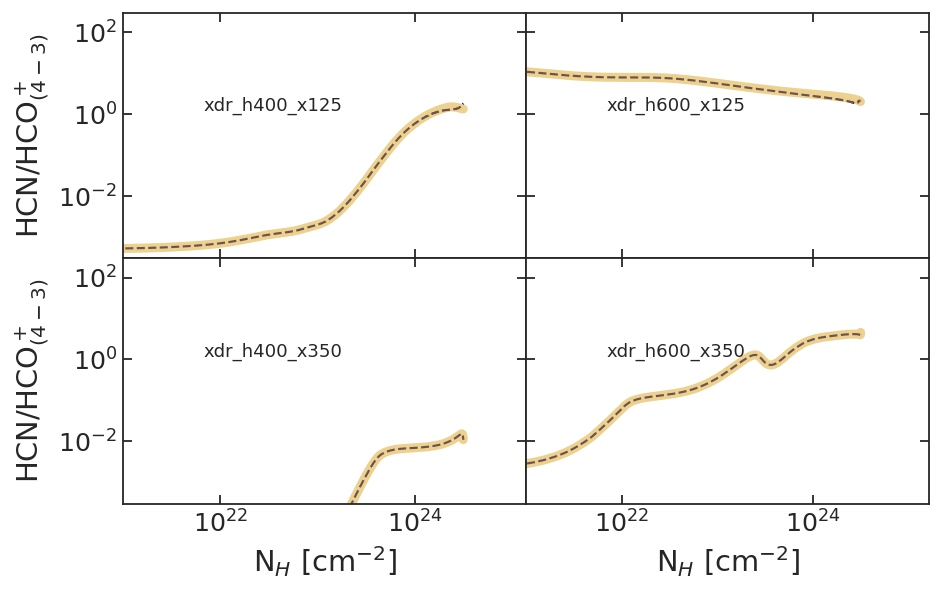

In [298]:
# XDR
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
filelist = ['xdr_h400_x125', 'xdr_h600_x125', 'xdr_h400_x350', 'xdr_h600_x350']

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
axs = [ax1, ax2, ax3, ax4]

# colors
c1, c2 = 'navy', 'goldenrod'
ls1, ls2 = 'dashed', 'solid'

for ax,ff in list(zip(axs, filelist)):
    hcn43 = old_lineNH(wd1, ff, 'HCN', 3)
    hcn43_NGM = old_lineNH(wd2, ff, 'HCN', 3)
    hco43 = old_lineNH(wd1, ff, 'HCO', 3)
    hco43_NGM = old_lineNH(wd2, ff, 'HCO', 3)
    pdr1 = ovrpdr(wd1, ff)[1]
    pdr2 = ovrpdr(wd2, ff)[1]
    ax.loglog(pdr1['H colden'], hcn43/hco43, c=c1, ls=ls1)
    ax.loglog(pdr2['H colden'], hcn43_NGM/hco43_NGM, c=c2, ls=ls2, lw=5, alpha=0.5)
    ax.text(0.2, 0.6, transform=ax.transAxes, size=10, s=ff)
    ax.set_xlim(left=1e21)
    ax.set_ylim([3e-4, 3e2])
    
for ax in axs:
    ax.set(xlabel=r'N$_H$ [cm$^{-2}$]', ylabel=r'HCN/HCO$^+_{(4-3)}$')
    ax.label_outer()

### HCN/HCO+ (J=4-3) <a class="anchor" id="hcnhco43"></a>
[(back to subtop)](#molratios)

In [245]:
# local (U)LIRGs data
ima18 = pd.read_csv('./data/imanishi18.csv', index_col = 'Name')
ima18[['HCN43_Lsun', 'HCN43_Lsun_err', 'HCO43_Lsun', 'HCO43_Lsun_err', 'HCNHCO43_Lsun', 'HCNHCO43_Lsun_err']]

,HCN43_Lsun,HCN43_Lsun_err,HCO43_Lsun,HCO43_Lsun_err,HCNHCO43_Lsun,HCNHCO43_Lsun_err
Name,,,,,,
IRAS08572+3915,7.30,0.70,9.7,0.7,0.795001,0.099375
IRAS19254-7245,25.00,2.00,16.0,1.0,1.590003,0.298125
IRAS12112+0305_NE,24.00,4.00,18.0,3.0,1.391252,0.298125
IRAS12112+0305_SW,NaN,NaN,5.9,2.2,NaN,NaN
IRAS22491-1808,30.00,2.00,22.0,2.0,1.391252,0.099375
NGC1614_Npeak,NaN,NaN,NaN,NaN,NaN,NaN
NGC1614_Speak,NaN,NaN,NaN,NaN,NaN,NaN
NGC1614_25rad,0.48,0.14,2.7,0.2,0.178875,0.059625
IRAS12127-1412,15.00,3.00,9.6,2.4,1.490627,0.496876


In [244]:
# NGC 1068 data
vit14 = pd.read_csv('./data/viti14.csv', index_col = 'Zone')
vit14[['HCN43_Kkm', 'HCN43_Kkm_err', 'HCO43_Kkm', 'HCO43_Kkm_err', 'HCNHCO43_Lsun', 'HCNHCO43_Lsun_err']]

,HCN43_Kkm,HCN43_Kkm_err,HCO43_Kkm,HCO43_Kkm_err,HCNHCO43_Lsun,HCNHCO43_Lsun_err
Zone,,,,,,
Eknot,639.47,95.9205,251.18,37.6770,2.498439,2.498439
Wknot,233.47,35.0205,82.18,12.3270,2.788037,2.788037
AGN,174.29,26.1435,82.52,12.3780,2.072750,2.072750
CND_N,130.02,19.5030,58.09,8.7135,2.196556,2.196556
CND_S,75.58,11.3370,27.73,4.1595,2.674796,2.674796
SBring,2.22,0.3330,2.22,0.3330,0.981372,0.981372


/tmp/ipykernel_14644/3192617477.py:10: RuntimeWarning: divide by zero encountered in log10
  im = ax3.imshow(np.log10(hcratio43_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
/tmp/ipykernel_14644/3192617477.py:11: RuntimeWarning: divide by zero encountered in log10
  im = ax4.imshow(np.log10(hcratio43_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')


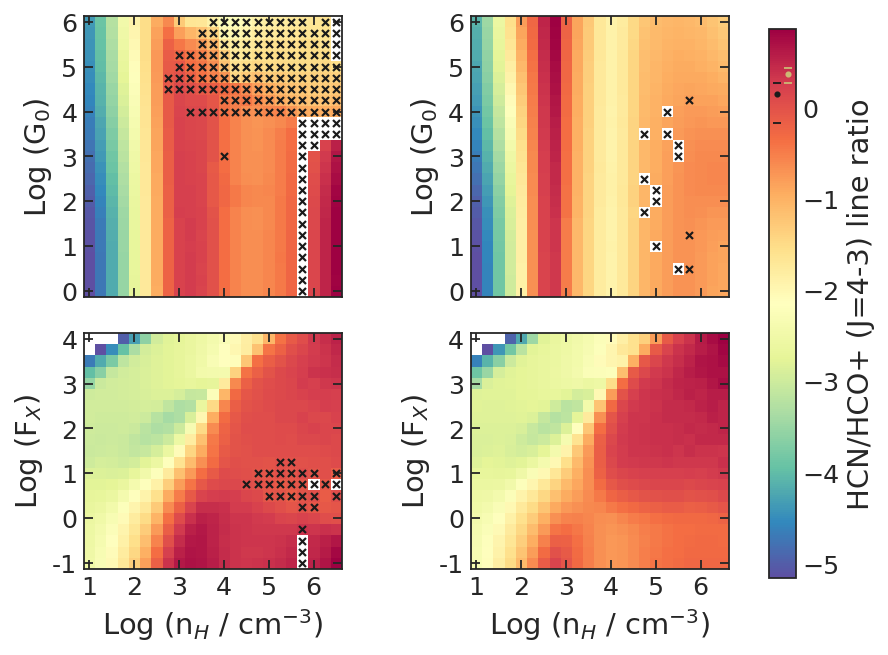

In [304]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
hcratio43_pdr = pd.read_csv(wd1 + 'HCN_HCOp_43_ratio_PDR.csv', index_col=0)
hcratio43_pdr_NGM = pd.read_csv(wd2 + 'HCN_HCOp_43_ratio_PDR.csv', index_col=0)
hcratio43_xdr = pd.read_csv(wd1 + 'HCN_HCOp_43_ratio_XDR.csv', index_col=0)
hcratio43_xdr_NGM = pd.read_csv(wd2 + 'HCN_HCOp_43_ratio_XDR.csv', index_col=0)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,8))
im = ax1.imshow(np.log10(hcratio43_pdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax2.imshow(np.log10(hcratio43_pdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax3.imshow(np.log10(hcratio43_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax4.imshow(np.log10(hcratio43_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')

# flagging "something went wrong" runs
for wd, ax in zip([wd1,wd2], [ax1,ax2]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'pdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            g = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, g*4, s=15, c='k', marker='x')
for wd, ax in zip([wd1,wd2], [ax3,ax4]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'xdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            x = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, (x+1)*4, s=15, c='k', marker='x')

for ax in [ax1,ax2]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,25,4)
    ax.set_yticks(yticks, (yticks/4).astype(int))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,21,4)
    ax.set_yticks(yticks, (yticks/4 - 1).astype(int))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label='HCN/HCO+ (J=4-3) line ratio')
cbar.ax.plot(0.3, np.log10(ima18['HCNHCO43_Lsun'].median()), 'k.')
cbar.ax.plot(0.3, np.log10(ima18['HCNHCO43_Lsun'].quantile(.16)), 'k_')
cbar.ax.plot(0.3, np.log10(ima18['HCNHCO43_Lsun'].quantile(.84)), 'k_')
cbar.ax.plot(0.7, np.log10(vit14['HCNHCO43_Lsun'].median()), 'y.')
cbar.ax.plot(0.7, np.log10(vit14['HCNHCO43_Lsun'].quantile(.16)), 'y_')
cbar.ax.plot(0.7, np.log10(vit14['HCNHCO43_Lsun'].quantile(.84)), 'y_');

### HCN/HCO+ (J=3-2) <a class="anchor" id="hcnhco32"></a>
[(back to subtop)](#molratios)

In [250]:
# local (U)LIRGs data
ima18 = pd.read_csv('./data/imanishi18.csv', index_col = 'Name')
ima18[['HCNHCO32_Lsun', 'HCNHCO32_Lsun_err']]

,HCNHCO32_Lsun,HCNHCO32_Lsun_err
Name,,
IRAS08572+3915,0.894383,0.099376
IRAS19254-7245,1.391262,0.198752
IRAS12112+0305_NE,1.788765,0.298128
IRAS12112+0305_SW,0.496879,0.198752
IRAS22491-1808,2.285644,0.198752
NGC1614_Npeak,NaN,NaN
NGC1614_Speak,NaN,NaN
NGC1614_25rad,0.327940,0.109313
IRAS12127-1412,1.291886,0.198752


/tmp/ipykernel_14644/2602502429.py:5: RuntimeWarning: divide by zero encountered in log10
  im = ax3.imshow(np.log10(hcratio32_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
/tmp/ipykernel_14644/2602502429.py:6: RuntimeWarning: divide by zero encountered in log10
  im = ax4.imshow(np.log10(hcratio32_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')


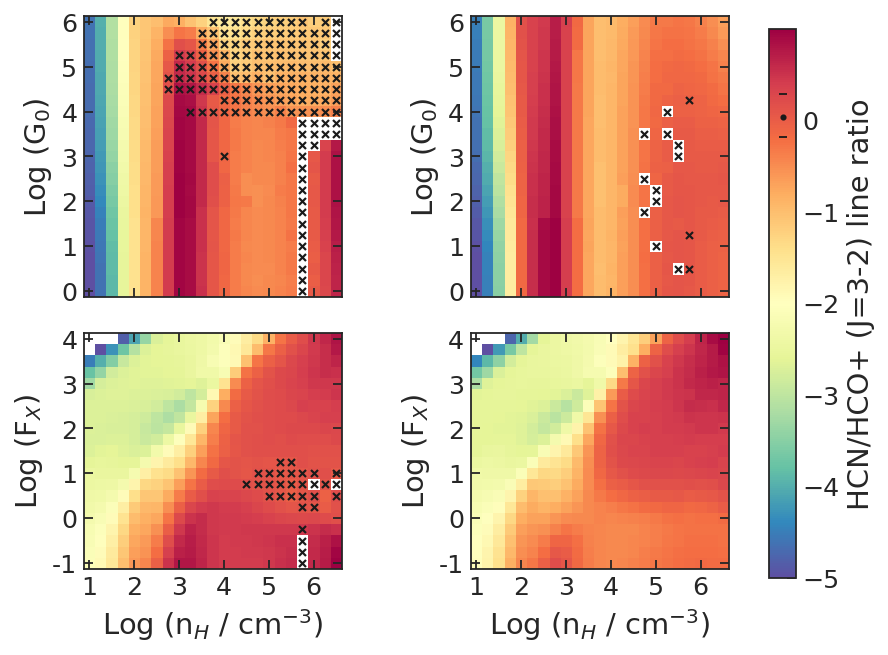

In [257]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,8))

im = ax1.imshow(np.log10(hcratio32_pdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax2.imshow(np.log10(hcratio32_pdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax3.imshow(np.log10(hcratio32_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax4.imshow(np.log10(hcratio32_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')


# flagging "something went wrong" runs
for wd, ax in zip([wd1,wd2], [ax1,ax2]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'pdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            g = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, g*4, s=15, c='k', marker='x')
for wd, ax in zip([wd1,wd2], [ax3,ax4]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'xdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            x = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, (x+1)*4, s=15, c='k', marker='x')

for ax in [ax1,ax2]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,25,4)
    ax.set_yticks(yticks, (yticks/4).astype(int))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,21,4)
    ax.set_yticks(yticks, (yticks/4 - 1).astype(int))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label='HCN/HCO+ (J=3-2) line ratio')
cbar.ax.plot(0.5, np.log10(ima18['HCNHCO32_Lsun'].median()), 'k.')
cbar.ax.plot(0.5, np.log10(ima18['HCNHCO32_Lsun'].quantile(.16)), 'k_')
cbar.ax.plot(0.5, np.log10(ima18['HCNHCO32_Lsun'].quantile(.84)), 'k_')

### HCN/HNC (J=4-3) <a class="anchor" id="hcnhnc43"></a>
[(back to subtop)](#molratios)

In [372]:
# local (U)LIRGs data
ima18 = pd.read_csv('./data/imanishi18.csv', index_col = 'Name')
ima18[['HCN43_Lsun', 'HCN43_Lsun_err', 'HNC43_Lsun', 'HNC43_Lsun_err', 'HCNHNC43_Lsun', 'HCNHNC43_Lsun_err']]

,HCN43_Lsun,HCN43_Lsun_err,HNC43_Lsun,HNC43_Lsun_err,HCNHNC43_Lsun,HCNHNC43_Lsun_err
Name,,,,,,
IRAS08572+3915,7.30,0.70,NaN,NaN,NaN,NaN
IRAS19254-7245,25.00,2.00,3.7,0.80,6.647641,1.759670
IRAS12112+0305_NE,24.00,4.00,37.0,4.00,0.586557,0.097759
IRAS12112+0305_SW,NaN,NaN,NaN,NaN,NaN,NaN
IRAS22491-1808,30.00,2.00,29.0,1.00,1.075354,0.097759
NGC1614_Npeak,NaN,NaN,NaN,NaN,NaN,NaN
NGC1614_Speak,NaN,NaN,NaN,NaN,NaN,NaN
NGC1614_25rad,0.48,0.14,0.3,0.09,1.564151,0.684316
IRAS12127-1412,15.00,3.00,12.0,3.00,1.270873,0.391038


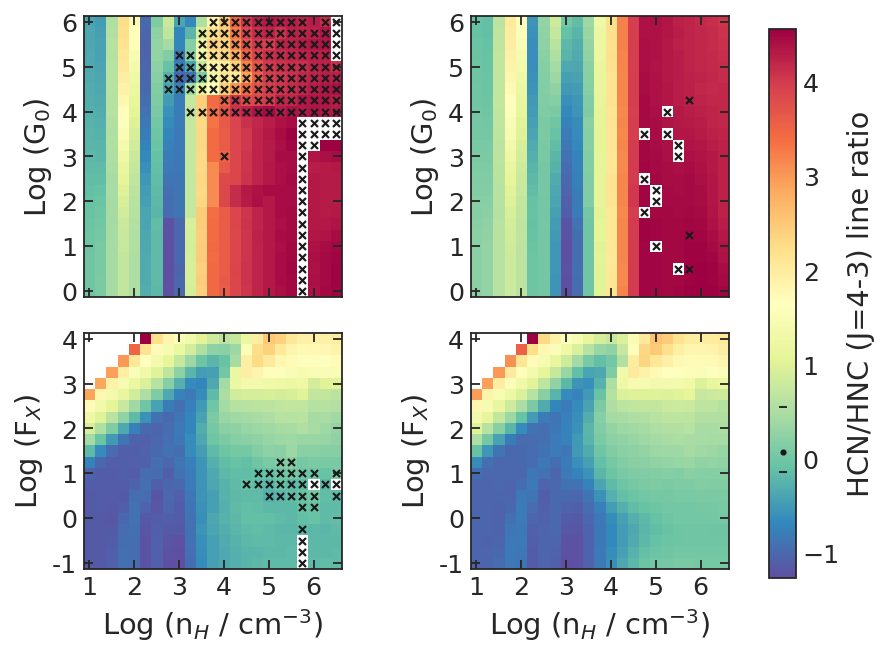

In [375]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
hnratio43_pdr = pd.read_csv(wd1 + 'HCN_HNC_43_ratio_PDR.csv', index_col=0)
hnratio43_pdr_NGM = pd.read_csv(wd2 + 'HCN_HNC_43_ratio_PDR.csv', index_col=0)
hnratio43_xdr = pd.read_csv(wd1 + 'HCN_HNC_43_ratio_XDR.csv', index_col=0)
hnratio43_xdr_NGM = pd.read_csv(wd2 + 'HCN_HNC_43_ratio_XDR.csv', index_col=0)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,8))
im = ax1.imshow(np.log10(hnratio43_pdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax2.imshow(np.log10(hnratio43_pdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax3.imshow(np.log10(hnratio43_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax4.imshow(np.log10(hnratio43_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')

# flagging "something went wrong" runs
for wd, ax in zip([wd1,wd2], [ax1,ax2]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'pdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            g = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, g*4, s=15, c='k', marker='x')
for wd, ax in zip([wd1,wd2], [ax3,ax4]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'xdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            x = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, (x+1)*4, s=15, c='k', marker='x')

for ax in [ax1,ax2]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,25,4)
    ax.set_yticks(yticks, (yticks/4).astype(int))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,21,4)
    ax.set_yticks(yticks, (yticks/4 - 1).astype(int))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label='HCN/HNC (J=4-3) line ratio')
cbar.ax.plot(0.5, np.log10(ima18['HCNHNC43_Lsun'].median()), 'k.')
cbar.ax.plot(0.5, np.log10(ima18['HCNHNC43_Lsun'].quantile(.16)), 'k_')
cbar.ax.plot(0.5, np.log10(ima18['HCNHNC43_Lsun'].quantile(.84)), 'k_');

### CO(13-12) / CO(6-5) <a class="anchor" id="co136"></a>
[(back to subtop)](#molratios)

In [319]:
# local (U)LIRGs data
esp22 = pd.read_csv('./data/cat_2022b.csv', index_col = 'Name')
no_ulim = (esp22['CO6_ulim'] == 0) & (esp22['CO13_ulim'] == 0)
esp22b = esp22[no_ulim][['CO6', 'CO6_lo', 'CO6_up', 'CO13', 'CO13_lo', 'CO13_up']].dropna()
esp22b['r136'] = esp22b['CO13'] / esp22b['CO6']
esp22b

,CO6,CO6_lo,CO6_up,CO13,CO13_lo,CO13_up,r136
Name,,,,,,,
NGC0034,4.650290e+06,2.776045e+05,2.824408e+05,2.341750e+06,2.115319e+05,2.140094e+05,0.503571
NGC1068,1.892121e+06,1.981956e+05,1.979104e+05,6.720492e+05,9.110330e+04,9.766636e+04,0.355183
3C84,2.110407e+06,1.276590e+05,1.376170e+05,1.354810e+06,2.897075e+05,2.743044e+05,0.641966
IRASF05189-2524,1.296572e+07,1.156238e+06,1.179899e+06,1.153044e+07,1.032981e+06,1.019756e+06,0.889302
UGC05101,1.260799e+07,8.789901e+05,8.481857e+05,4.864881e+06,1.269502e+06,1.269502e+06,0.385857
Mrk0231,2.162228e+07,1.258400e+06,1.236358e+06,1.698529e+07,1.134519e+06,1.172782e+06,0.785545
MCG-03-34-064,9.282518e+05,1.461222e+05,1.326127e+05,1.389578e+06,5.737338e+05,5.882263e+05,1.496984
NGC5135,4.083398e+06,4.396715e+05,4.403365e+05,4.416671e+05,6.463421e+04,6.463421e+04,0.108162
VV705,6.766697e+06,1.214318e+06,1.071477e+06,5.044120e+06,2.218597e+06,2.657216e+06,0.745433


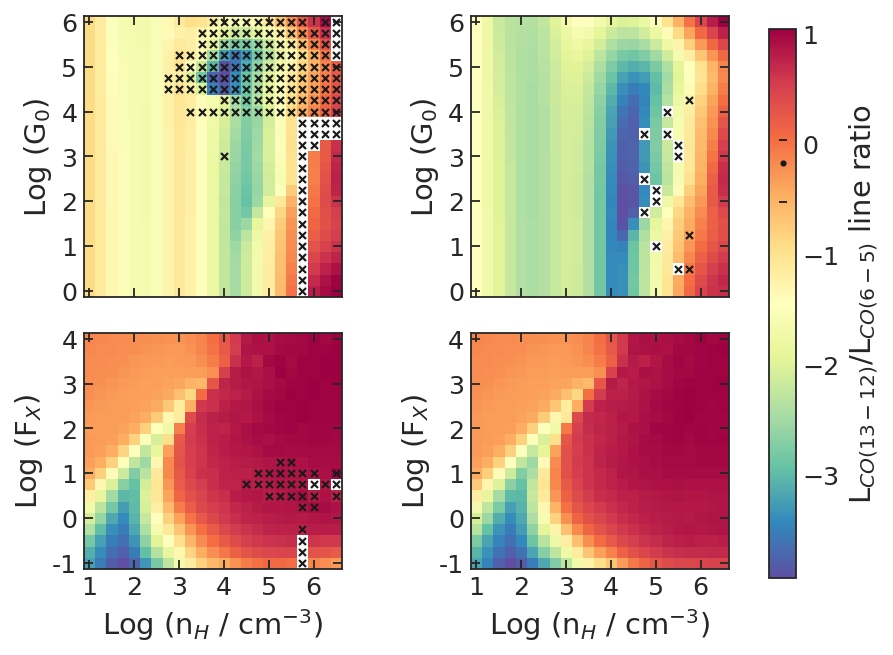

In [356]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
co136_pdr = pd.read_csv(wd1 + 'CO_136_ratio_PDR.csv', index_col=0)
co136_pdr_NGM = pd.read_csv(wd2 + 'CO_136_ratio_PDR.csv', index_col=0)
co136_xdr = pd.read_csv(wd1 + 'CO_136_ratio_XDR.csv', index_col=0)
co136_xdr_NGM = pd.read_csv(wd2 + 'CO_136_ratio_XDR.csv', index_col=0)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,8))
im = ax1.imshow(np.log10(co136_pdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax2.imshow(np.log10(co136_pdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax3.imshow(np.log10(co136_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax4.imshow(np.log10(co136_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')

# flagging "something went wrong" runs
for wd, ax in zip([wd1,wd2], [ax1,ax2]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'pdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            g = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, g*4, s=15, c='k', marker='x')
for wd, ax in zip([wd1,wd2], [ax3,ax4]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'xdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            x = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, (x+1)*4, s=15, c='k', marker='x')

for ax in [ax1,ax2]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,25,4)
    ax.set_yticks(yticks, (yticks/4).astype(int))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,21,4)
    ax.set_yticks(yticks, (yticks/4 - 1).astype(int))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label=r'L$_{CO(13-12)}$/L$_{CO(6-5)}$ line ratio')
cbar.ax.plot(0.5, np.log10(esp22b['r136'].median()), 'k.')
cbar.ax.plot(0.5, np.log10(esp22b['r136'].quantile(.16)), 'k_')
cbar.ax.plot(0.5, np.log10(esp22b['r136'].quantile(.84)), 'k_');

### CO(6-5) / CO(1-0) <a class="anchor" id="co61"></a>
[(back to subtop)](#molratios)

In [366]:
# local (U)LIRGs data
CO1 = ['CO1', 'CO1tot', 'CO1rCO', 'CO1nuc'][3]
esp22 = pd.read_csv('./data/cat_2022b.csv', index_col = 'Name')
no_ulim = (esp22['CO6_ulim'] == 0) & (esp22['CO1_ulim'] == 0)
esp22b = esp22[no_ulim][[CO1, CO1 + '_lo', CO1 + '_up', 'CO6', 'CO6_lo', 'CO6_up']].dropna()
esp22b['r61'] = esp22b['CO6'] / esp22b[CO1]
print(len(esp22b))
esp22b

25


,CO1nuc,CO1nuc_lo,CO1nuc_up,CO6,CO6_lo,CO6_up,r61
Name,,,,,,,
NGC0034,14340.451890,2868.090378,2868.090378,4.650290e+06,2.776045e+05,2.824408e+05,324.277813
NGC1068,19485.811720,541.264988,541.264988,1.892121e+06,1.981956e+05,1.979104e+05,97.102485
3C84,3152.150465,30.309139,30.309139,2.110407e+06,1.276590e+05,1.376170e+05,669.513458
NGC1365,3639.422258,727.884452,727.884452,3.805550e+06,1.142173e+06,1.142173e+06,1045.646619
IRASF05189-2524,18505.210111,2698.676555,2698.676555,1.296572e+07,1.156238e+06,1.179899e+06,700.652643
IRAS07598+6508,6813.713420,344.185750,344.185750,5.045937e+07,1.192676e+07,1.192676e+07,7405.561047
UGC05101,8637.905636,1727.581127,1727.581127,1.260799e+07,8.789901e+05,8.481857e+05,1459.611946
NGC3227,2497.283655,107.274932,107.274932,2.749373e+05,2.562975e+04,2.096980e+04,110.094551
NGC4388,1365.433652,273.086730,273.086730,8.795434e+05,1.028038e+05,9.345798e+04,644.149514


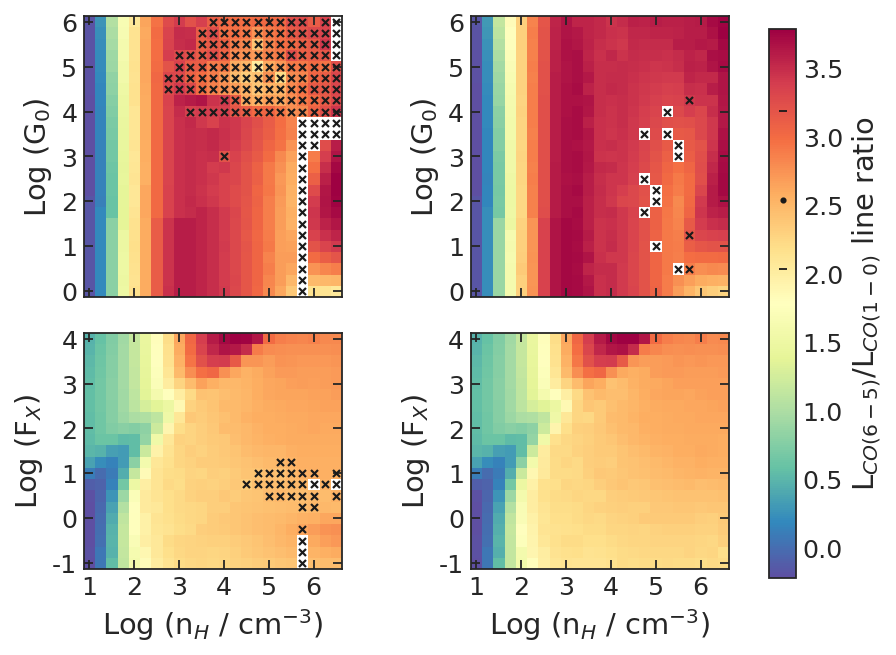

In [365]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
co61_pdr = pd.read_csv(wd1 + 'CO_61_ratio_PDR.csv', index_col=0)
co61_pdr_NGM = pd.read_csv(wd2 + 'CO_61_ratio_PDR.csv', index_col=0)
co61_xdr = pd.read_csv(wd1 + 'CO_61_ratio_XDR.csv', index_col=0)
co61_xdr_NGM = pd.read_csv(wd2 + 'CO_61_ratio_XDR.csv', index_col=0)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,8))
im = ax1.imshow(np.log10(co61_pdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax2.imshow(np.log10(co61_pdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax3.imshow(np.log10(co61_xdr.T.astype(np.float64)), origin='lower', cmap='Spectral_r')
im = ax4.imshow(np.log10(co61_xdr_NGM.T.astype(np.float64)), origin='lower', cmap='Spectral_r')

# flagging "something went wrong" runs
for wd, ax in zip([wd1,wd2], [ax1,ax2]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'pdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            g = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, g*4, s=15, c='k', marker='x')
for wd, ax in zip([wd1,wd2], [ax3,ax4]):
    for ff in pd.read_csv(wd + 'swwlist.csv', squeeze=True).to_list():
        if ff[:3] == 'xdr':
            h = float(ff.split('.')[0].split('_')[1][1:])/100
            x = float(ff.split('.')[0].split('_')[2][1:])/100
            ax.scatter((h-1)*4, (x+1)*4, s=15, c='k', marker='x')

for ax in [ax1,ax2]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,25,4)
    ax.set_yticks(yticks, (yticks/4).astype(int))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    xticks = np.arange(0,23,4)
    ax.set_xticks(xticks, (xticks/4 + 1).astype(int))
    yticks = np.arange(0,21,4)
    ax.set_yticks(yticks, (yticks/4 - 1).astype(int))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label=r'L$_{CO(6-5)}$/L$_{CO(1-0)}$ line ratio')
cbar.ax.plot(0.5, np.log10(esp22b['r61'].median()), 'k.')
cbar.ax.plot(0.5, np.log10(esp22b['r61'].quantile(.16)), 'k_')
cbar.ax.plot(0.5, np.log10(esp22b['r61'].quantile(.84)), 'k_');

### CO selected line ratios <a class="anchor" id="coratios"></a>
[(back to subtop)](#molratios)

In [425]:
df = pd.read_csv('./data/cat_2022b.csv', index_col='Name')
rat = pd.read_csv('/media/phd/catalogo/CO1nuc.csv', index_col='Name').loc[df.index]
pdf = df.loc[df[df['CO1_ulim'] == 0]['logG0500pc'].dropna().index]
xdf = df.loc[df[df['CO1_ulim'] == 0]['logFX'].dropna().index]
prat = rat.loc[pdf.index]
xrat = rat.loc[xdf.index]

# Livia old simulations
pdr = np.load('/media/phd/cloudy/livia/PDRgrid_emissivities_ergscm-2.npy')
xdr = np.load('/media/phd/cloudy/livia/XDRgrid_emissivities_ergscm-2.npy')
hden = np.array([2, 3, 4, 5, 6])
g0 = np.array([2, 3, 4, 5])
fx = np.arange(-0.5, 3, 0.5)
pdr = pdr[:13]
xdr = xdr[:13]

# present simulations
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
co61_pdr_NGM = pd.read_csv(wd2 + 'CO_61_ratio_PDR.csv', index_col=0)
co81_pdr_NGM = pd.read_csv(wd2 + 'CO_81_ratio_PDR.csv', index_col=0)
co131_pdr_NGM = pd.read_csv(wd2 + 'CO_131_ratio_PDR.csv', index_col=0)
co61_xdr_NGM = pd.read_csv(wd2 + 'CO_61_ratio_XDR.csv', index_col=0)
co81_xdr_NGM = pd.read_csv(wd2 + 'CO_81_ratio_XDR.csv', index_col=0)
co131_xdr_NGM = pd.read_csv(wd2 + 'CO_131_ratio_XDR.csv', index_col=0)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,5))
for ax, co in zip(fig.get_axes(), ['r61', 'r81', 'r131']):
    j = int(co[1:-1])
    for i in range(len(hden)):
        fact = (co_mm[j-1] / co_mm[0])**3
        ax.plot(g0, np.log10(fact*pdr[j-1,i,:]/pdr[0,i,:]), marker='o', ms=5, c=cm.viridis_r(i*50), lw=2,
                label='log(n) = ' + str(hden[i]))
        if j==6: this = co61_pdr.loc['h' + str(hden[i]*100)] * fact
        elif j==8: this = co81_pdr_NGM.loc['h' + str(hden[i]*100)] * fact
        elif j==13: this = co131_pdr_NGM.loc['h' + str(hden[i]*100)] * fact
        ax.plot(g0, np.log10(this[['g' + str(G*100) for G in g0]]), marker='*', ms=5, c=cm.viridis_r(i*50), lw=2, 
                ls='dashed', label='log(n) = ' + str(hden[i]))
    yy = np.log10(prat[co]).dropna()
    xx = pdf['logG0500pc'].loc[yy.index]
    ylo = - np.log10(1 - (prat[co+'_lo'] / prat[co])).loc[yy.index]
    yup = np.log10(1 + (prat[co+'_up'] / prat[co])).loc[yy.index]
    yulim = prat[co+'_ulim'].loc[yy.index]
    ax.errorbar(xx, yy, yerr=[ylo, yup], uplims=yulim,
                fmt='s', ms=5, alpha=0.5, c='k', capsize=3, elinewidth=2)
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(-3.1, 3.1)
    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylabel(r'Log (L$^{\prime}_{CO(J \rightarrow J-1)}$ / L$^{\prime}_{CO(1-0)})$')
    ax.text(x=0.5, y=0.91, transform=ax.transAxes, size=20, horizontalalignment='center',
            s='CO(' + co[1:-1] +'-'+ str(int(co[1:-1])-1) + ')', 
            bbox=dict(facecolor='white',edgecolor='black',boxstyle='round'))
    ax.set_xlabel(r'Log G$_0$ (250 pc)')
    ax.tick_params(top=True, right=True)
    ax.label_outer()

plt.subplots_adjust(top=0.93, wspace=0., hspace=0.05)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,5))
for ax, co in zip(fig.get_axes(), ['r61', 'r81', 'r131']):
    j = int(co[1:-1])
    for i in range(len(hden)):
        fact = (co_mm[j-1] / co_mm[0])**3
        ax.plot(fx, np.log10(fact*xdr[j-1,i,:]/xdr[0,i,:]), marker='o', ms=5, c=cm.viridis_r(i*50), lw=2,
                label='log(n) = ' + str(hden[i]))
        if j==6: this = co61_xdr.loc['h' + str(hden[i]*100)] * fact
        elif j==8: this = co81_xdr_NGM.loc['h' + str(hden[i]*100)] * fact
        elif j==13: this = co131_xdr_NGM.loc['h' + str(hden[i]*100)] * fact
        ax.plot(fx, np.log10(this[['x' + ('%.2f' % X).replace('.', '') for X in fx]]), 
                marker='*', ms=5, c=cm.viridis_r(i*50), lw=2, ls='dashed', label='log(n) = ' + str(hden[i]))
    yy = np.log10(xrat[co]).dropna()
    xx = xdf['logFX'].loc[yy.index]
    ylo = - np.log10(1 - (xrat[co+'_lo'] / xrat[co])).loc[yy.index]
    yup = np.log10(1 + (xrat[co+'_up'] / xrat[co])).loc[yy.index]
    yulim = xrat[co+'_ulim'].loc[yy.index]
    ax.errorbar(xx, yy, yerr=[ylo, yup], uplims=yulim,
                fmt='s', ms=5, alpha=0.5, c='k', capsize=3, elinewidth=2)
    ax.set_xlim(-1.5, 2.5)
    ax.set_xticks([-1, 0, 1, 2])
    ax.set_ylim(-3.1, 3.1)
    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylabel(r'Log (L$^{\prime}_{CO(J \rightarrow J-1)}$ / L$^{\prime}_{CO(1-0)})$')
    ax.text(x=0.5, y=0.91, transform=ax.transAxes, size=20, horizontalalignment='center',
            s='CO(' + co[1:-1] +'-'+ str(int(co[1:-1])-1) + ')', 
            bbox=dict(facecolor='white',edgecolor='black',boxstyle='round'))
    ax.set_xlabel(r'Log F$_X$ (250 pc)')
    ax.tick_params(top=True, right=True)
    ax.label_outer()

plt.subplots_adjust(top=0.93, wspace=0., hspace=0.05)

***
***
***

# Maximize CO(1-0) luminosity <a class="anchor" id="maxCO1"></a>
[(back to top)](#toc)

In [10]:
# generate CO(1-0) grids at the deepest column density
lnam = 'CO1'
wd = '/media/phd/cloudy/hagrid/'

emili = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name')
llab = emili.loc[lnam, 'line']
hden, G0, FX = np.arange(0, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                    columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                    columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
pbar = ProgressBar()
for h in pbar(hden):
    hname = 'h' + ('%.2f' % h).replace('.', '')
    for g in G0:
        gname = 'g' + ('%03d' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        pdr.loc[hname, gname] = emis(wd, ff)[llab].iloc[-1]
    for x in FX:
        xname = 'x' + ('%03d' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        xdr.loc[hname, xname] = emis(wd, ff)[llab].iloc[-1]
        
pdr.to_csv(wd + lnam + '_emissivity_PDR.csv')
xdr.to_csv(wd + lnam + '_emissivity_XDR.csv')

100% |#########################################################################|


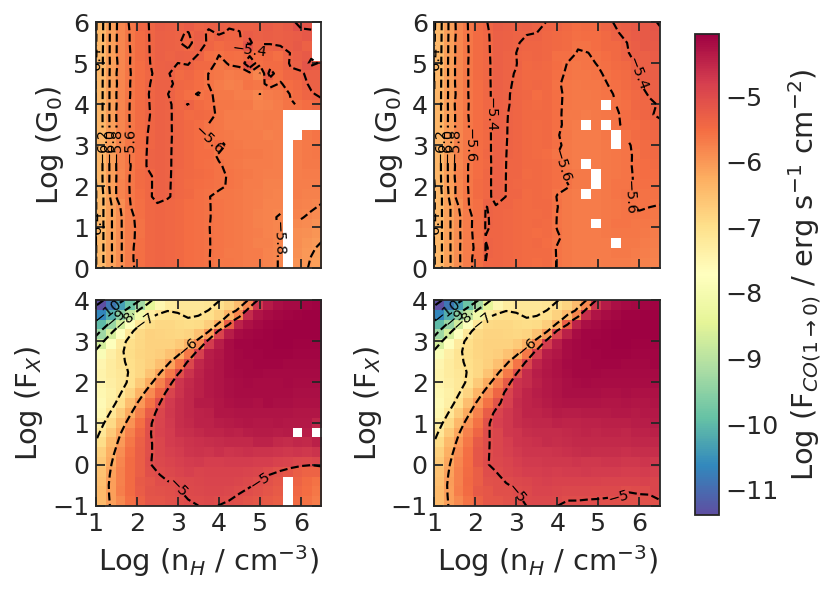

In [79]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
CO1_pdr = np.log10(pd.read_csv(wd1 + 'CO1_emissivity_PDR.csv', index_col=0))
CO1_pdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_emissivity_PDR.csv', index_col=0))
CO1_xdr = np.log10(pd.read_csv(wd1 + 'CO1_emissivity_XDR.csv', index_col=0))
CO1_xdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_emissivity_XDR.csv', index_col=0))

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7,7))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [CO1_pdr, CO1_pdr_NGM, CO1_xdr, CO1_xdr_NGM]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [CO1_pdr, CO1_pdr_NGM, CO1_xdr, CO1_xdr_NGM]])

CP1 = ax1.contour(hden, G0+2.8, CO1_pdr.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(CO1_pdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP2 = ax2.contour(hden, G0+2.8, CO1_pdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(CO1_pdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP3 = ax3.contour(hden, FX, CO1_xdr.T.astype(np.float64), levels=7, colors='black')
ax3.clabel(CP3, inline=True, fontsize=8, colors='black')
im = ax3.imshow(CO1_xdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

CP4 = ax4.contour(hden, FX, CO1_xdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax4.clabel(CP4, inline=True, fontsize=8, colors='black')
im = ax4.imshow(CO1_xdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

# plot properties
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(1,7,1))
    ax.set_yticks(np.arange(0,7,1))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    ax.set_xticks(np.arange(1,7,1))
    ax.set_yticks(np.arange(-1,5,1))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, 
                    label=r'Log (F$_{CO(1 \rightarrow 0)}$ / erg s$^{-1}$ cm$^{-2}$)')

It seems the results do not change considerably between the two grids. 

We can also calculate the luminosity of each Cloudy run instead of the flux: 
- each run has a fixed gas density $n_H$
- we extract the CO(1-0) flux from the last line, i.e. from the maximum column density $N_H = 10^{24.5}$ cm$^{-2}$
- the luminosity will be $L = 4 \pi R^2 F$ where $R = N_H / n_H$

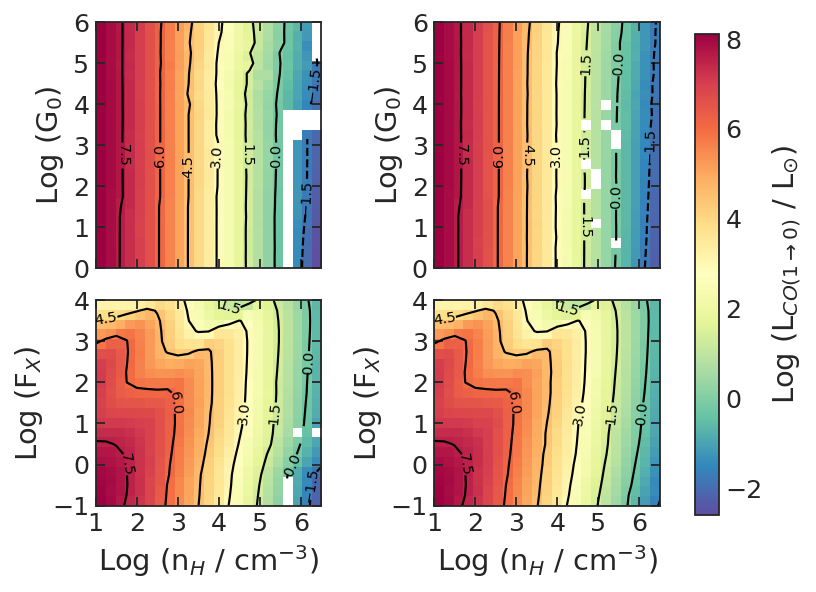

In [80]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
CO1_pdr = np.log10(pd.read_csv(wd1 + 'CO1_emissivity_PDR.csv', index_col=0))
CO1_pdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_emissivity_PDR.csv', index_col=0))
CO1_xdr = np.log10(pd.read_csv(wd1 + 'CO1_emissivity_XDR.csv', index_col=0))
CO1_xdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_emissivity_XDR.csv', index_col=0))

NH = 10**(24.5)
for hh in CO1_pdr.index:
    nH = 10**(int(hh[1:])/1e2)
    for ndr in [CO1_pdr, CO1_pdr_NGM, CO1_xdr, CO1_xdr_NGM]:
        ndr.loc[hh] = ndr.loc[hh] + np.log10(4 * np.pi * (NH/nH)**2 / lsun)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7,7))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [CO1_pdr, CO1_pdr_NGM, CO1_xdr, CO1_xdr_NGM]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [CO1_pdr, CO1_pdr_NGM, CO1_xdr, CO1_xdr_NGM]])

CP1 = ax1.contour(hden, G0+2.8, CO1_pdr.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(CO1_pdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP2 = ax2.contour(hden, G0+2.8, CO1_pdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(CO1_pdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP3 = ax3.contour(hden, FX, CO1_xdr.T.astype(np.float64), levels=7, colors='black')
ax3.clabel(CP3, inline=True, fontsize=8, colors='black')
im = ax3.imshow(CO1_xdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

CP4 = ax4.contour(hden, FX, CO1_xdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax4.clabel(CP4, inline=True, fontsize=8, colors='black')
im = ax4.imshow(CO1_xdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

# plot properties
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(1,7,1))
    ax.set_yticks(np.arange(0,7,1))
    ax.set_ylabel('Log (G$_0$)');
for ax in [ax3,ax4]:
    ax.set_xticks(np.arange(1,7,1))
    ax.set_yticks(np.arange(-1,5,1))
    ax.set_ylabel('Log (F$_X$)');

ax3.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
ax4.set_xlabel('Log (n$_H$ / cm$^{-3}$)')
plt.subplots_adjust(hspace=-0.4, wspace=0.5)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2,ax3,ax4], shrink=0.7, label=r'Log (L$_{CO(1 \rightarrow 0)}$ / L$_{\odot}$)')

In [57]:
print('Since each Cloudy run (both PDR and XDR) has log(NH/cm^-2) = 24.5:\n')
for nh in hden:
    print('log(n/cm^-3) = %.2f' % nh, '==> R = %.2E' % (10**(24.5 - nh) / pc), 'pc')

Since each Cloudy run (both PDR and XDR) has log(NH/cm^-2) = 24.5:

log(n/cm^-3) = 0.00 ==> R = 1.02E+06 pc
log(n/cm^-3) = 0.25 ==> R = 5.76E+05 pc
log(n/cm^-3) = 0.50 ==> R = 3.24E+05 pc
log(n/cm^-3) = 0.75 ==> R = 1.82E+05 pc
log(n/cm^-3) = 1.00 ==> R = 1.02E+05 pc
log(n/cm^-3) = 1.25 ==> R = 5.76E+04 pc
log(n/cm^-3) = 1.50 ==> R = 3.24E+04 pc
log(n/cm^-3) = 1.75 ==> R = 1.82E+04 pc
log(n/cm^-3) = 2.00 ==> R = 1.02E+04 pc
log(n/cm^-3) = 2.25 ==> R = 5.76E+03 pc
log(n/cm^-3) = 2.50 ==> R = 3.24E+03 pc
log(n/cm^-3) = 2.75 ==> R = 1.82E+03 pc
log(n/cm^-3) = 3.00 ==> R = 1.02E+03 pc
log(n/cm^-3) = 3.25 ==> R = 5.76E+02 pc
log(n/cm^-3) = 3.50 ==> R = 3.24E+02 pc
log(n/cm^-3) = 3.75 ==> R = 1.82E+02 pc
log(n/cm^-3) = 4.00 ==> R = 1.02E+02 pc
log(n/cm^-3) = 4.25 ==> R = 5.76E+01 pc
log(n/cm^-3) = 4.50 ==> R = 3.24E+01 pc
log(n/cm^-3) = 4.75 ==> R = 1.82E+01 pc
log(n/cm^-3) = 5.00 ==> R = 1.02E+01 pc
log(n/cm^-3) = 5.25 ==> R = 5.76E+00 pc
log(n/cm^-3) = 5.50 ==> R = 3.24E+00 pc
log(n/cm^-3)

This is assuming always the deepest column density, $\log(N_H / cm^{-2}) = 24.5$, which is higher than any clump extracted within a fiducial GMC. In fact, as shown on the following plot, most of the clumps are around $\log(N_H / cm^{-2}) = 21.5$.

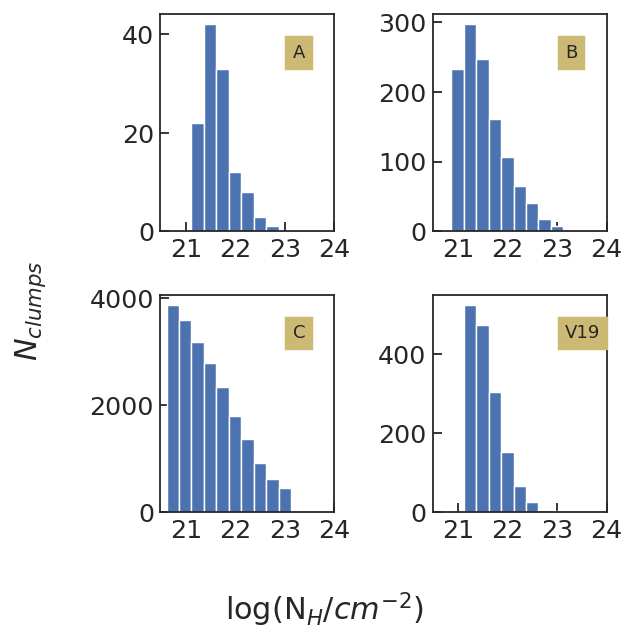

In [2]:
from gmc_module import *

# calculating the bins so they are uniform on every subplot
_, bins, patches = plt.hist(pd.read_csv(gmcV19.ndf)['logNH'])
plt.close()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(5,5), sharex=False)
axlist = [ax1, ax2, ax3, ax4]

for ax, gmc in zip(axlist, gmclist):
    ax.hist(pd.read_csv(gmc.ndf)['logNH'], bins=bins, label=gmc.name)
    ax.set_xticks([21,22,23,24])
    ax.text(s=gmc.name, x=0.76, y=0.8, transform=ax.transAxes, size=10, backgroundcolor='y')

fig.supxlabel('log(N$_H / cm^{-2}$)')
fig.supylabel('$N_{clumps}$')
fig.tight_layout();

## CO(1-0) at $\log(N_H / cm^{-2}) = 21.5$

In [189]:
# generate CO(1-0) grids at logNH=21.5
wd = '/media/phd/cloudy/hagrid/'
logNH = 21.5
line_name = 'CO1'
line_label = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name').loc[line_name, 'line']

hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                    columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                    columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
pbar = ProgressBar()
for h in pbar(hden):
    hname = 'h' + ('%.2f' % h).replace('.', '')
    for g in G0:
        gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        pdr.loc[hname, gname] = lineNH(wd, ff, line_label, logNH)
    for x in FX:
        xname = 'x' + ('%.2f' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        xdr.loc[hname, xname] = lineNH(wd, ff, line_label, logNH)
        
pdr.to_csv(wd + lnam + '_logNH215_emissivity_PDR.csv')
xdr.to_csv(wd + lnam + '_logNH215_emissivity_XDR.csv')

100% |#########################################################################|


/tmp/ipykernel_10350/1458074410.py:3: RuntimeWarning: divide by zero encountered in log10
  CO1_pdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH215_emissivity_PDR.csv', index_col=0))
/tmp/ipykernel_10350/1458074410.py:4: RuntimeWarning: divide by zero encountered in log10
  CO1_xdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH215_emissivity_XDR.csv', index_col=0))


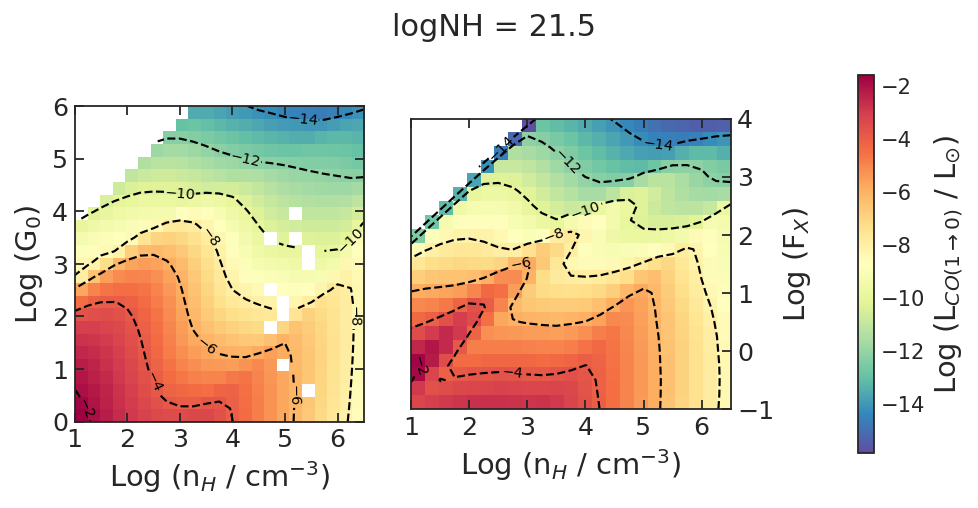

In [52]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
logNH = 21.5
CO1_pdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH215_emissivity_PDR.csv', index_col=0))
CO1_xdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH215_emissivity_XDR.csv', index_col=0))

NH = 10**logNH
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
for hh in CO1_pdr_NGM.index:
    nH = 10**(int(hh[1:])/1e2)
    for ndr in [CO1_pdr_NGM, CO1_xdr_NGM]:
        ndr.loc[hh] = ndr.loc[hh] + np.log10(4 * np.pi * (NH/nH)**2 / lsun)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [CO1_pdr_NGM, CO1_xdr_NGM]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [CO1_pdr_NGM, CO1_xdr_NGM]])

CP1 = ax1.contour(hden, G0+2.8, CO1_pdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(CO1_pdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP2 = ax2.contour(hden, FX, CO1_xdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(CO1_xdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

# plot properties
ax1.set_yticks(np.arange(0,7,1))
ax1.set_ylabel('Log (G$_0$)');
ax2.set_yticks(np.arange(-1,5,1))
ax2.set_ylabel('Log (F$_X$)');
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(1,7,1))
    ax.set_xlabel('Log (n$_H$ / cm$^{-3}$)')

cax = ax2.inset_axes([1.4, -0.15, 0.05, 1.3], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax, label=r'Log (L$_{CO(1 \rightarrow 0)}$ / L$_{\odot}$)')
cbar.ax.tick_params(labelsize='small')
fig.suptitle('logNH = %.1f' % logNH)
plt.tight_layout();

## CO(1-0) at $\log(N_H / cm^{-2}) = 22.5$

In [44]:
# generate CO(1-0) grids at logNH=22.5
wd = '/media/phd/cloudy/ngmgrid/'
logNH = 22.
line_name = 'CO1'
line_label = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name').loc[line_name, 'line']

hden, G0, FX = np.arange(0, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                   columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                   columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
pbar = ProgressBar()
for h in pbar(hden):
    hname = 'h' + ('%.2f' % h).replace('.', '')
    for g in G0:
        gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
        ff = 'pdr_' + hname + '_' + gname
        pdr.loc[hname, gname] = lineNH(wd, ff, line_label, logNH)
    for x in FX:
        xname = 'x' + ('%.2f' % x).replace('.', '')
        ff = 'xdr_' + hname + '_' + xname
        xdr.loc[hname, xname] = lineNH(wd, ff, line_label, logNH)
        
pdr.to_csv(wd + line_name + '_logNH22_emissivity_PDR.csv')
xdr.to_csv(wd + line_name + '_logNH22_emissivity_XDR.csv')

100% |#########################################################################|


In [1]:
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
logNH = 22.
CO1_pdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH22_emissivity_PDR.csv', index_col=0))
CO1_xdr_NGM = np.log10(pd.read_csv(wd2 + 'CO1_logNH22_emissivity_XDR.csv', index_col=0))
hden, G0, FX = np.arange(0, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

NH = 10**logNH
for hh in CO1_pdr_NGM.index:
    nH = 10**(int(hh[1:])/1e2)
    for ndr in [CO1_pdr_NGM, CO1_xdr_NGM]:
        ndr.loc[hh] = ndr.loc[hh] + np.log10(4 * np.pi * (NH/nH)**2 / lsun)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [CO1_pdr_NGM, CO1_xdr_NGM]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [CO1_pdr_NGM, CO1_xdr_NGM]])

CP1 = ax1.contour(hden, G0+2.8, CO1_pdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(CO1_pdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])

CP2 = ax2.contour(hden, FX, CO1_xdr_NGM.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(CO1_xdr_NGM.T.astype(np.float64), origin='lower', cmap='Spectral_r',
               vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], FX[0], FX[-1]])

# plot properties
ax1.set_yticks(np.arange(0,7,1))
ax1.set_ylabel('Log (G$_0$)');
ax2.set_yticks(np.arange(-1,5,1))
ax2.set_ylabel('Log (F$_X$)');
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xlabel('Log (n$_H$ / cm$^{-3}$)')

cax = ax2.inset_axes([1.4, -0.15, 0.05, 1.3], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax, label=r'Log (L$_{CO(1 \rightarrow 0)}$ / L$_{\odot}$)')
cbar.ax.tick_params(labelsize='small')
fig.suptitle('logNH = %.1f' % logNH)
plt.tight_layout();

NameError: name 'np' is not defined

***
***
***

# THE DIFFERENT CLOUDY GRIDS

***

# The `turbogrid` <a class="anchor" id="turbogrid"></a>
[(back to top)](#toc)

#### Main parameters

```
table star "vallini18_Zsun.mod" age=10e6 years  # PDR case
table xdr                                       # XDR case
turbulence 15 km/s
CMB
cosmic rays background
database H2
abundances GASS no grains
grains ISM no qheat
metals and grains linear 1
no grain molecules
stop temperature off
stop column density 24.5
iterate to convergence
```

In [4]:
from gmc_module import *
wd = '/media/phd/cloudy/turbogrid/'

In [5]:
hden = np.arange(0, 6.75, 0.25)        # cm^-3
logG0 = np.arange(0, 6.2, 0.25)[::-1]  # 6-13.6 eV
logFX = np.arange(-1, 4.2, 0.25)[::-1] # 1-100 keV

print('TURBOGRID: final report\n---------')
print(len(hden) * (len(logG0) + len(logFX)), 'total Cloudy runs')
print('1238 Cloudy ends')
print('1172 Cloudy exited OK')
print('  66 something went wrong')
print('   4 this is bad')

TURBOGRID: final report
---------
1242 total Cloudy runs
1238 Cloudy ends
1172 Cloudy exited OK
  66 something went wrong
   4 this is bad


In [6]:
ef0 = error_finder(wd, 'Cloudy exited OK')
ef1 = error_finder(wd, 'something went wrong')
ef2 = error_finder(wd, 'this is bad')
print(len(list(set(ef1).intersection(ef2))), 'intersections')
swwlist = sorted(ef1 + ef2)

Looking for Cloudy exited OK in 1242 files...
→ found it in 1172 files!
Looking for something went wrong in 1242 files...
→ found it in 66 files!
Looking for this is bad in 1242 files...
→ found it in 4 files!
0 intersections


In [29]:
# save results to csv
pd.Series(swwlist).to_csv(wd + 'swwlist.csv', header=False, index=False)

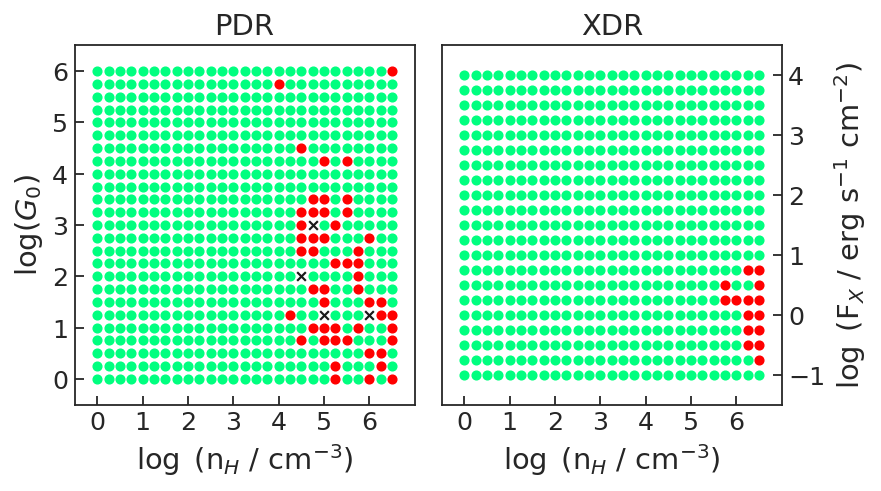

In [7]:
savefig = False
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharex=True)

for ef, c, m in zip([ef0, ef1, ef2], 
                    ['springgreen', 'red', 'k'], 
                    ['o', 'o', 'x']):
    pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
    for f in ef:
        fparts = f.split('_')
        hden = float(fparts[1].split('h')[1])/100
        if fparts[0] == 'pdr':
            pdr_h.append(hden)
            pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
        if fparts[0] == 'xdr':
            xdr_h.append(hden)
            xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

    ax1.scatter(pdr_h, pdr_g, color=c, marker=m)
    ax2.scatter(xdr_h, xdr_x, color=c, marker=m)

ax1.set_title('PDR')
ax1.set_ylim([-0.5, 6.5])
ax1.set_ylabel(r'$\log (G_0)$')
ax2.set_title('XDR')
ax2.set_ylim([-1.5, 4.5])
ax2.set_ylabel(r'$\log$ (F$_X$ / erg s$^{-1}$ cm$^{-2}$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xlim([-0.5, 7])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xlabel(r'$\log$ (n$_H$ / cm$^{-3}$)')
fig.tight_layout()

if savefig:
    fig.savefig(wd + 'grid_failures.png', dpi=300, bbox_inches='tight')

#### Generate CO(1-0) grids at logNH=24.5

In [1]:
from gmc_module import *

In [2]:
lnam = 'CO1'
wd = '/media/phd/cloudy/turbogrid/'

emili = pd.read_csv(wd + 'emis_lines.csv', index_col='Name')
llab = emili.loc[lnam, 'line']
pdr = pd.DataFrame(index=hnames, columns=gnames[::-1])
xdr = pd.DataFrame(index=hnames, columns=xnames[::-1])
pbar = ProgressBar()
for h in pbar(hnames):
    for g in gnames:
        ff = 'pdr_' + h + '_' + g
        try: pdr.loc[h, g] = emis(wd, ff)[llab].iloc[-1]
        except IndexError: pdr.loc[h, g] = np.nan
    for x in xnames:
        ff = 'xdr_' + h + '_' + x
        try: xdr.loc[h, x] = emis(wd, ff)[llab].iloc[-1]
        except IndexError: xdr.loc[h, g] = np.nan

pdr.to_csv(wd + lnam + '_emissivity_PDR.csv')
xdr.to_csv(wd + lnam + '_emissivity_XDR.csv')

100% |#########################################################################|


/tmp/ipykernel_13573/2504165274.py:3: RuntimeWarning: divide by zero encountered in log10
  CO1_xdr = np.log10(pd.read_csv(wd + 'CO1_emissivity_XDR.csv', index_col=0))


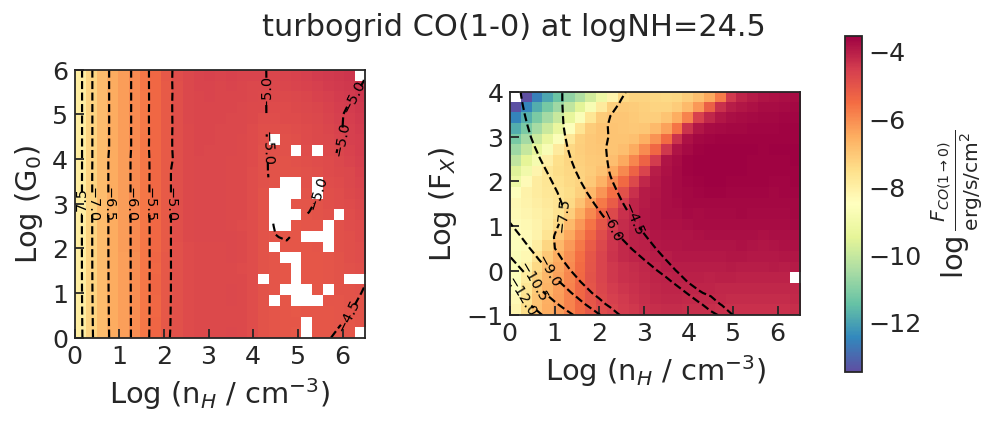

In [22]:
wd = '/media/phd/cloudy/turbogrid/'
CO1_pdr = np.log10(pd.read_csv(wd + 'CO1_emissivity_PDR.csv', index_col=0))
CO1_xdr = np.log10(pd.read_csv(wd + 'CO1_emissivity_XDR.csv', index_col=0))

# convert to luminosity
NH = 10**(24.5)
#for hh in CO1_pdr.index:
#    nH = 10**(int(hh[1:])/1e2)
#    for ndr in [CO1_pdr, CO1_xdr]:
#        ndr.loc[hh] = ndr.loc[hh] + np.log10(4 * np.pi * (NH/nH)**2 / lsun)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9,5.5))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [CO1_pdr, CO1_xdr]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [CO1_pdr, CO1_xdr]])

CP1 = ax1.contour(hden, logG0, CO1_pdr.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(CO1_pdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
                vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], logG0[-1], logG0[0]])
ax1.set_yticks(np.arange(0,7,1))
ax1.set_ylabel('Log (G$_0$)')

CP2 = ax2.contour(hden, logFX, CO1_xdr.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(CO1_xdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
                vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], logFX[-1], logFX[0]])
ax2.set_yticks(np.arange(-1,5,1))
ax2.set_ylabel('Log (F$_X$)')

# plot properties
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xlabel('Log (n$_H$ / cm$^{-3}$)')

fig.suptitle('turbogrid CO(1-0) at logNH=24.5')
plt.subplots_adjust(hspace=-0.4, wspace=0.5, top=1.3)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2], shrink=0.4, 
                    #label=r'Log (L$_{CO(1 \rightarrow 0)}$ / L$_{\odot}$)')
                    label=r'$\log \frac{F_{CO(1 \rightarrow 0)}}{\mathrm{erg/s/cm}^{2}}$')

#### Generate CO(1-0) grids at different logNH

In [1]:
from gmc_module import *

In [33]:
wd = '/media/phd/cloudy/turbogrid/'
line_name = 'CO1'
logNH_list = [22., 22.5, 23., 23.5, 24., 24.5]
for logNH in logNH_list:
    line_pdr, line_xdr = grid_lineNH(wd, line_name, logNH, save=True)

/tmp/ipykernel_20190/1119137187.py:6: RuntimeWarning: divide by zero encountered in log10
  line_pdr, line_xdr = np.log10(line_pdr), np.log10(line_xdr)


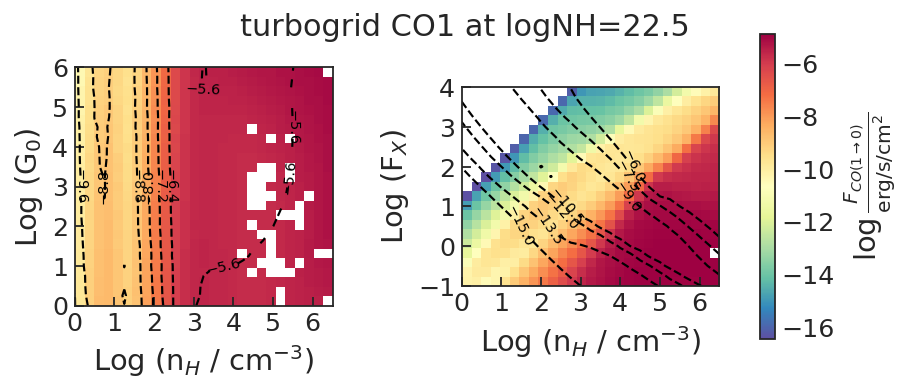

In [16]:
wd = '/media/phd/cloudy/turbogrid/'
logNH = 22.5
line_name = 'CO1' # edit cbar_label too!
plot_units = ['flux', 'lsun'][0]
line_pdr, line_xdr = grid_lineNH(wd, line_name, logNH, save=True)
line_pdr, line_xdr = np.log10(line_pdr), np.log10(line_xdr)

if plot_units == 'lsun':
    cbar_label=r'Log (L$_{CO(1 \rightarrow 0)}$ / L$_{\odot}$)'
    NH = 10**(logNH)
    for ndr in [line_pdr, line_xdr]:
        for hh in ndr.index:
            nH = 10**(int(hh[1:])/1e2)
            ndr.loc[hh] = ndr.loc[hh] + np.log10(4 * np.pi * (NH/nH)**2 / lsun)
elif plot_units == 'flux':
    cbar_label=r'$\log \frac{F_{CO(1 \rightarrow 0)}}{\mathrm{erg/s/cm}^{2}}$'

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,5))
vmin = np.min([ndr[np.isfinite(ndr)].min().min() for ndr in [line_pdr, line_xdr]])
vmax = np.max([ndr[np.isfinite(ndr)].max().max() for ndr in [line_pdr, line_xdr]])

CP1 = ax1.contour(hden, logG0, line_pdr.T.astype(np.float64), levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(line_pdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
                vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], logG0[-1], logG0[0]])
ax1.set_yticks(np.arange(0,7,1))
ax1.set_ylabel('Log (G$_0$)')

CP2 = ax2.contour(hden, logFX, line_xdr.T.astype(np.float64), levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(line_xdr.T.astype(np.float64), origin='lower', cmap='Spectral_r',
                vmin=vmin, vmax=vmax, extent=[hden[0], hden[-1], logFX[-1], logFX[0]])
ax2.set_yticks(np.arange(-1,5,1))
ax2.set_ylabel('Log (F$_X$)')

# plot properties
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xlabel('Log (n$_H$ / cm$^{-3}$)')

fig.suptitle(wd.split('/')[-2] + ' ' + line_name + ' at logNH=%.1f' % logNH)
plt.subplots_adjust(hspace=-0.4, wspace=0.5, top=1.3)

# colorbar
cbar = plt.colorbar(im, ax=[ax1,ax2], shrink=0.4, label=cbar_label)